# Подготовительная задача 1

Сделать из линейной регрессии nn.sequental двухслойную сеть

# Подготовительная задача 2

Добавить в np и torch реализации баесы

# Подготовительная задача 3 

В реализациях на np и разных вариантах на torch рисовать графики loss(iteration) и gradients(iterations)

# Задача

Повторить обучение на mnist из прошлой домашки:
 	
Используя структуру сети Sequental в pytorch реализовать и обучить классификатор цифр из MNIST

1. Количество слоев от 1 до 4
2. Разные размеры скрытых слоев: 5, 10, 50, 100, 300
3. С разными функциями активации (без, ReLU, sigmoid, tanh)
4. С разными функциями потерь (CrossEntropy, MSE)
5. Со смещениями и без.

Каждый пункт 2-3 варианта.

Результат в форме отчета: скорость и качество обучения от параметров сети.
Везде где имеет смысл нарисовать графики.

Объяснить разницу в обучении с разными параметрами.

In [218]:
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
import torch
from torch.autograd import Variable
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from timeit import default_timer as timer  
%matplotlib inline  

In [261]:
mnist = fetch_mldata('MNIST original')

In [193]:
X_FULL = mnist.data 
Y_FULL = mnist.target

In [253]:
X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(
      X_FULL, Y_FULL, test_size=0.33)

In [195]:
dtype = torch.FloatTensor
X_TRAIN = Variable(torch.from_numpy(X_TRAIN).type(dtype), requires_grad=False)
Y_TRAIN = Variable(torch.from_numpy(Y_TRAIN).type(torch.LongTensor), requires_grad=False)
X_TEST = Variable(torch.from_numpy(X_TEST).type(dtype), requires_grad=False)
Y_TEST = Variable(torch.from_numpy(Y_TEST).type(torch.LongTensor), requires_grad=False)


In [212]:
def print_work_time(func):
    def wrapper(*args, **kwargs):
        start = timer()
        result = func(*args, **kwargs)
        end = timer()
        print("Execution take {}".format(end - start))
        return result
    return wrapper

Напишем функцию для тестирования различных архитектур 

In [213]:
from collections import defaultdict
import sys

@print_work_time
def learn_on_model(X, Y, model, loss_fn, X_test = None, Y_test = None, learning_rate = 1e-1, epoch_temp = 2, temp_change = np.log(10), batch_size = 15, max_epoch_num = 20, min_loss = 1e-3):
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)    
    loss = 1000
    epoch_num = 0
     
    loss_arr = np.zeros(max_epoch_num)

    test_loss_arr = np.zeros(max_epoch_num) if not (type(X_test) is None) else None
    layer_arr = [ [ np.zeros(max_epoch_num)\
                   for param in child.parameters()] for child in model.children()]
    y_pred = model(X)
    loss = loss_fn(y_pred, Y)
    #sys.stdout.write("Before learning Loss : {0:.2f}\n".format(loss.data.tolist()[0]))
    optimizer.zero_grad()
    
    while loss > min_loss and epoch_num < max_epoch_num:
 
        #sys.stdout.write("Epoch {} ... ".format(epoch_num + 1))
        for bn, start in enumerate(xrange(0, X_TRAIN.size()[0], batch_size)):
            X_CUR = X[start:start + batch_size]
            Y_CUR = Y[start:start + batch_size]
            y_pred = model(X_CUR)
            loss = loss_fn(y_pred, Y_CUR)
            optimizer.zero_grad()
        
            loss.backward()

            optimizer.step()
        
        y_pred = model(X)
        loss = loss_fn(y_pred, Y)
        loss.backward()
        loss = loss.data.tolist()[0]
        #sys.stdout.write("Loss : {0:.2f}\n".format(loss))
        loss_arr[epoch_num] = loss

        
        for ind1, child in enumerate(model.children()):
            for ind2, param in enumerate(child.parameters()):
                layer_arr[ind1][ind2][epoch_num] = (param.grad ** 2).mean().sqrt().data.tolist()[0]
        
        if not (type(X_test) is None):
            y_pred = model(X_test)
            loss = loss_fn(y_pred, Y_test).data.tolist()[0]
            test_loss_arr[epoch_num] = loss
            
            
        epoch_num += 1
        
        if epoch_num % epoch_temp == 0:
            learning_rate /= temp_change
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
            #print ("Cur learning rate {}".format(learning_rate))

    return loss_arr, layer_arr, test_loss_arr
    

И функцию для визуализации результатов обучения

In [214]:
def draw_plots(model, loss_arr, layer_arr, test_loss_arr):
    x = np.arange(loss_arr.shape[0]);
    number_of_plots = 1 + sum(len(x) for x in layer_arr)
    gridSize = number_of_plots
    plt.figure(figsize=(15, 6 * number_of_plots))
    
    plotId = 1
    subpl = plt.subplot(gridSize, 1, plotId)
    if not type(test_loss_arr) is None:
        subpl.plot(x, loss_arr, x, test_loss_arr)
        subpl.legend(["Train", "Test"])
    else:
        subpl.plot(x, loss_arr)
    subpl.set_xticks(range(x.shape[0]))
    subpl.set_title("Loss function")
    subpl.set_xlabel("Epoch num")
    subpl.set_ylabel("Loss func")
    
    for ind1, child in enumerate(model.children()):
        for ind2, key in enumerate(child.state_dict().keys()):
            plotId += 1
            subpl = plt.subplot(gridSize, 1, plotId)
            y = layer_arr[ind1][ind2]
            subpl.plot(x, y)
            
            subpl.set_xticks(range(x.shape[0]))
            subpl.set_title("Layer {} : {} gradient norm".format(ind1 + 1, key))
            subpl.set_xlabel("Epoch num")
            subpl.set_ylabel(key + "_grad")
    
    plt.show()


    

И функцию для подсчета качества предсказания нашей модели на тренировочной и тестовой выборке

In [282]:
from sklearn.metrics import classification_report

def make_classification_report(model, X_TRAIN, Y_TRAIN, X_TEST, Y_TEST):
    print ("Train report")
    y_predicted = model.forward(X_TRAIN)
    maxs, indices = torch.max(y_predicted, 1)
    print (classification_report(np.array(Y_TRAIN.data.tolist()), np.array(indices.data.tolist())))
    
    print ("Test report")
    y_predicted = model.forward(X_TEST)
    maxs, indices = torch.max(y_predicted, 1)
    print (classification_report(np.array(Y_TEST.data.tolist()), np.array(indices.data.tolist())))
    


In [216]:
print (X_TRAIN.size(), Y_TRAIN.size(), X_TEST.size(), Y_TEST.size())

(torch.Size([46900, 784]), torch.Size([46900]), torch.Size([23100, 784]), torch.Size([23100]))


Опробуем сначала одну из самых простых архитектур. В качестве функции ошибки будет использовать NLLLoss

Execution take 69.4673881531


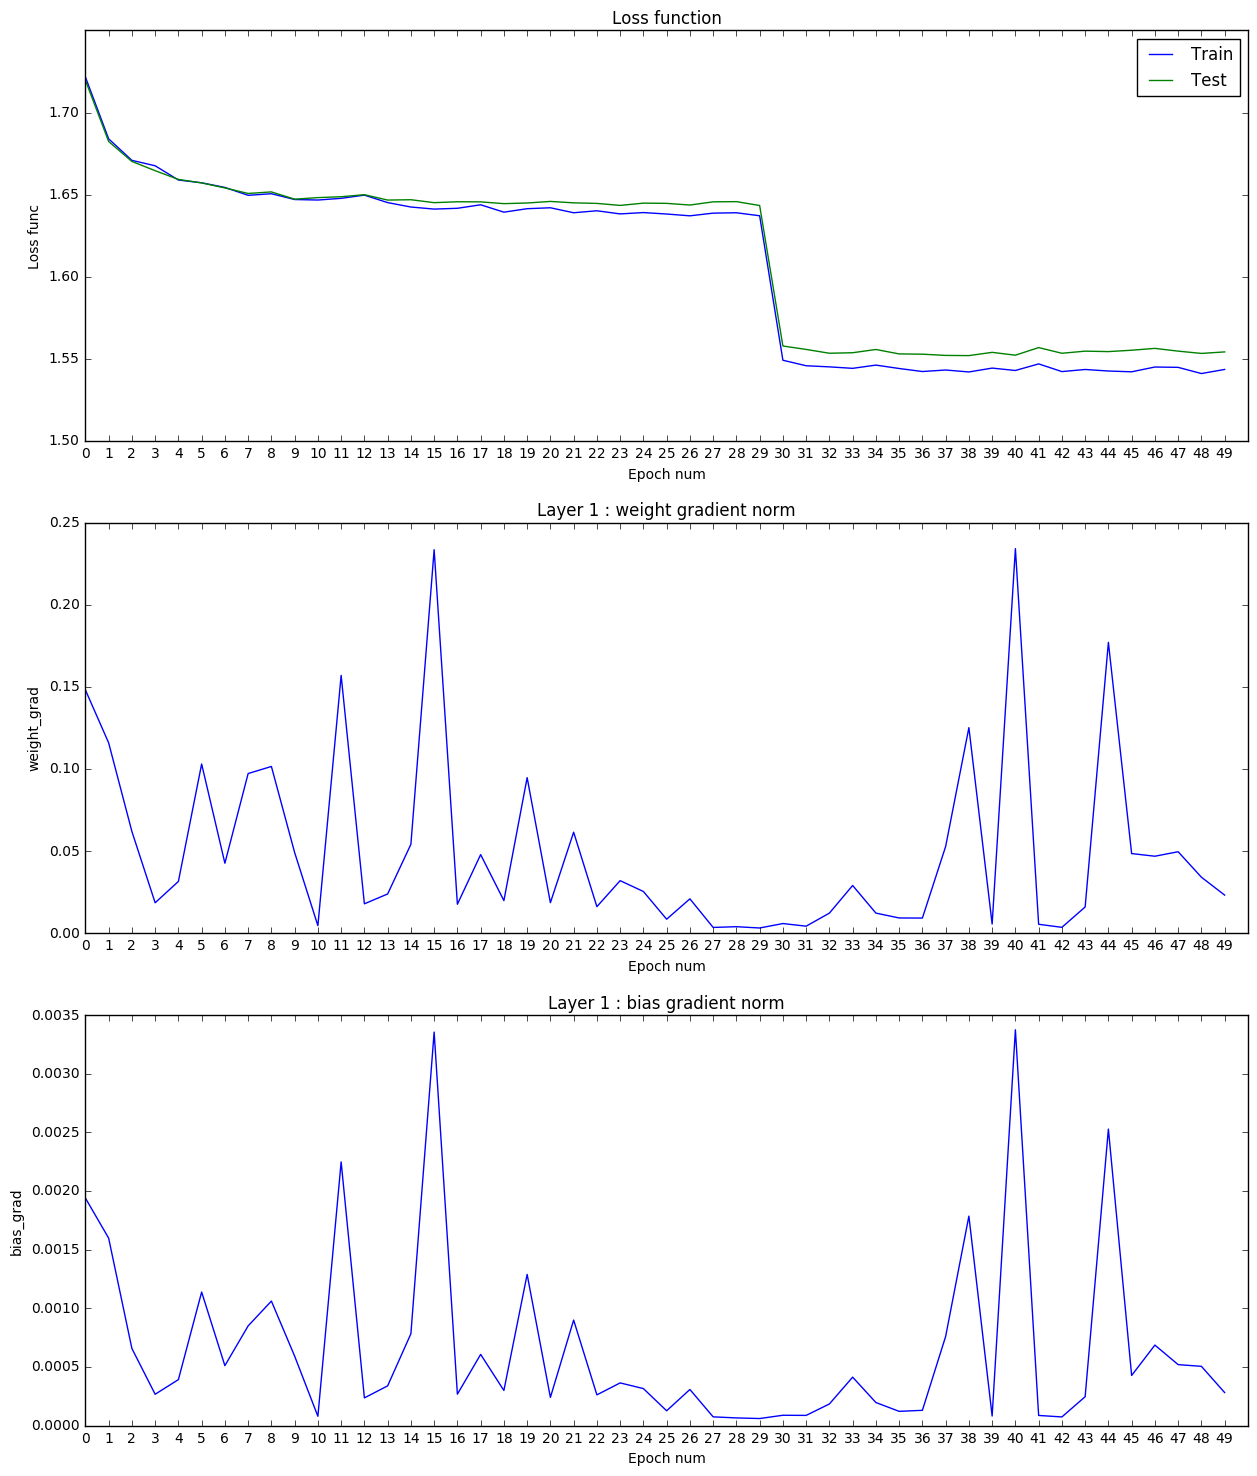

Train report
             precision    recall  f1-score   support

          0       0.81      0.99      0.89      4674
          1       0.95      0.98      0.96      5334
          2       0.89      0.92      0.90      4669
          3       0.87      0.88      0.87      4822
          4       0.89      0.94      0.91      4571
          5       0.82      0.82      0.82      4146
          6       0.97      0.88      0.93      4553
          7       0.90      0.92      0.91      4867
          8       0.90      0.81      0.85      4552
          9       0.96      0.80      0.87      4712

avg / total       0.90      0.89      0.89     46900

Test report
             precision    recall  f1-score   support

          0       0.79      0.99      0.88      2229
          1       0.96      0.98      0.97      2543
          2       0.88      0.91      0.90      2321
          3       0.86      0.88      0.87      2319
          4       0.88      0.93      0.91      2253
          5      

In [219]:
D_in = 784
D_out = 10 
model = torch.nn.Sequential(
          torch.nn.Linear(D_in, D_out),
          torch.nn.Sigmoid(),
          torch.nn.LogSoftmax()
)
loss_fn = torch.nn.NLLLoss(size_average=True)


learning_rate = 1e-4

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


loss_arr, layer_arr, test_loss_arr = learn_on_model(X_TRAIN, Y_TRAIN, model, loss_fn, X_TEST,\
                                                    Y_TEST,\
                                                    learning_rate, epoch_temp = 1000, temp_change = 1,\
                                                    max_epoch_num=50, batch_size = 32)

draw_plots(model, loss_arr, layer_arr, test_loss_arr)
make_classification_report(model, X_TRAIN, Y_TRAIN, X_TEST, Y_TEST)

Видим, что качество предсказания даже на сравнительно простой архитектуре уже неплохо. 
Попробуем его улучшить введением скрытого слоя

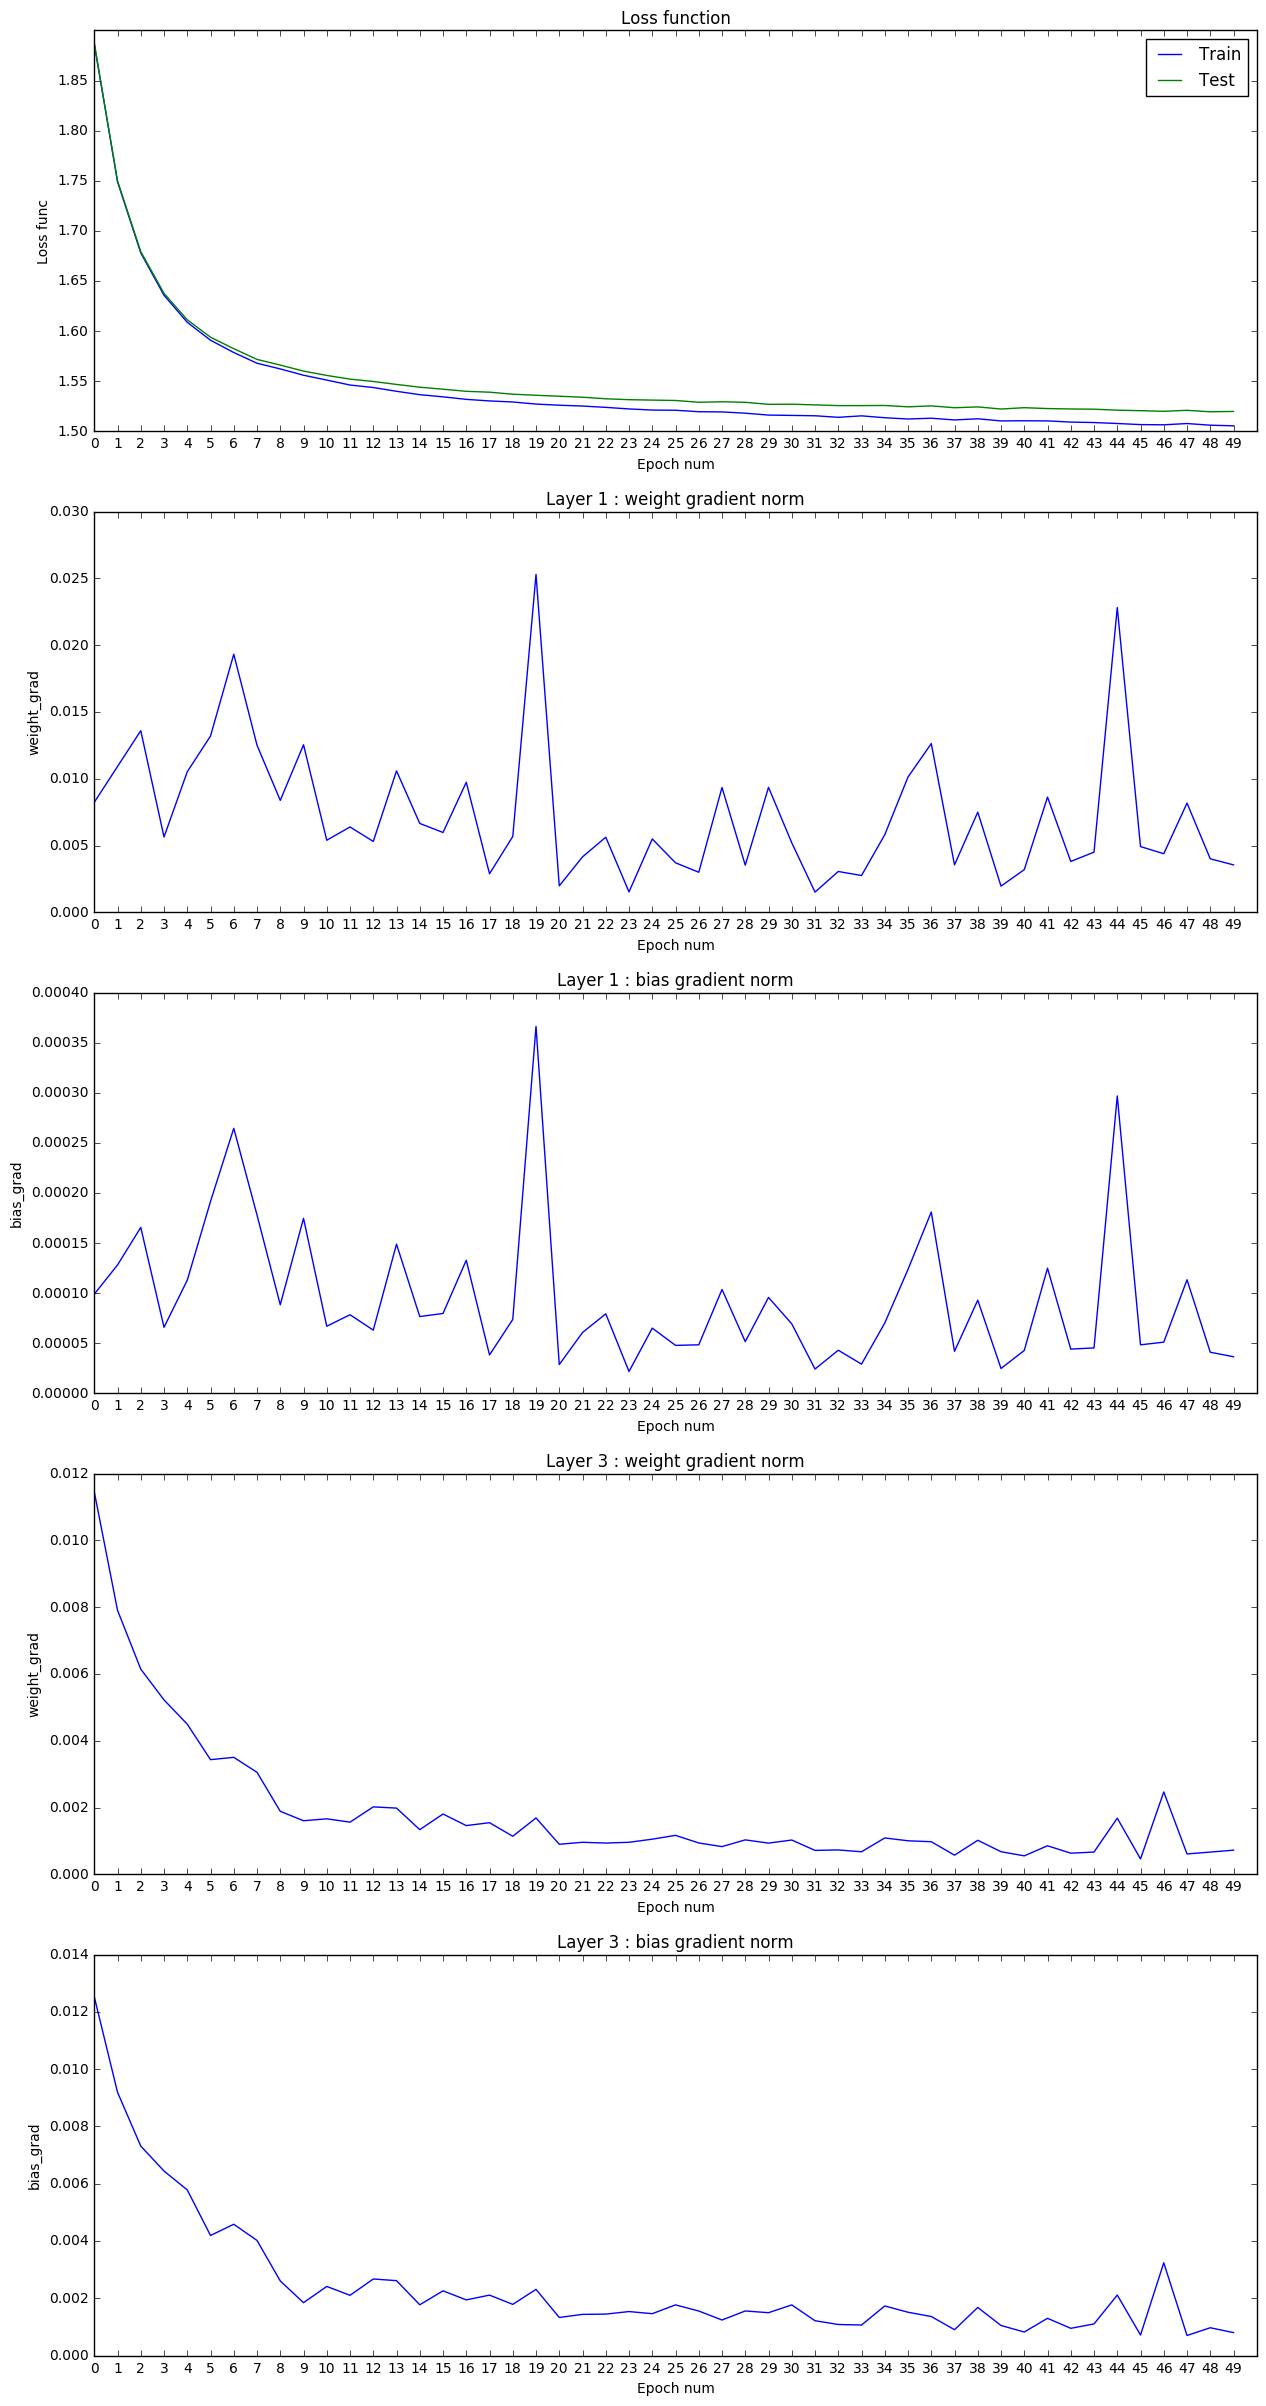

Train report
             precision    recall  f1-score   support

          0       0.97      0.98      0.98      4674
          1       0.98      0.98      0.98      5334
          2       0.95      0.95      0.95      4669
          3       0.94      0.94      0.94      4822
          4       0.94      0.97      0.96      4571
          5       0.95      0.93      0.94      4146
          6       0.97      0.97      0.97      4553
          7       0.97      0.96      0.97      4867
          8       0.95      0.94      0.94      4552
          9       0.96      0.95      0.95      4712

avg / total       0.96      0.96      0.96     46900

Test report
             precision    recall  f1-score   support

          0       0.96      0.97      0.96      2229
          1       0.98      0.98      0.98      2543
          2       0.93      0.92      0.93      2321
          3       0.92      0.93      0.93      2319
          4       0.92      0.96      0.94      2253
          5      

In [202]:
D_in = 784
D_out = 10
D_deep = 50 
model = torch.nn.Sequential(
          torch.nn.Linear(D_in, D_deep),
          torch.nn.Sigmoid(),
          torch.nn.Linear(D_deep, D_out),
          torch.nn.Sigmoid(),
          torch.nn.LogSoftmax()
)
loss_fn = torch.nn.NLLLoss(size_average=True)


learning_rate = 1e-4

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


loss_arr, layer_arr, test_loss_arr = learn_on_model(X_TRAIN, Y_TRAIN, model, loss_fn, X_TEST,\
                                                    Y_TEST,\
                                                    learning_rate, epoch_temp = 1000, temp_change = 1,\
                                                    max_epoch_num=50, batch_size = 32)

draw_plots(model, loss_arr, layer_arr, test_loss_arr)
make_classification_report(model, X_TRAIN, Y_TRAIN, X_TEST, Y_TEST)

Качество улучшилось. Попробуем с увеличенным числом нейронов в скрытом слое

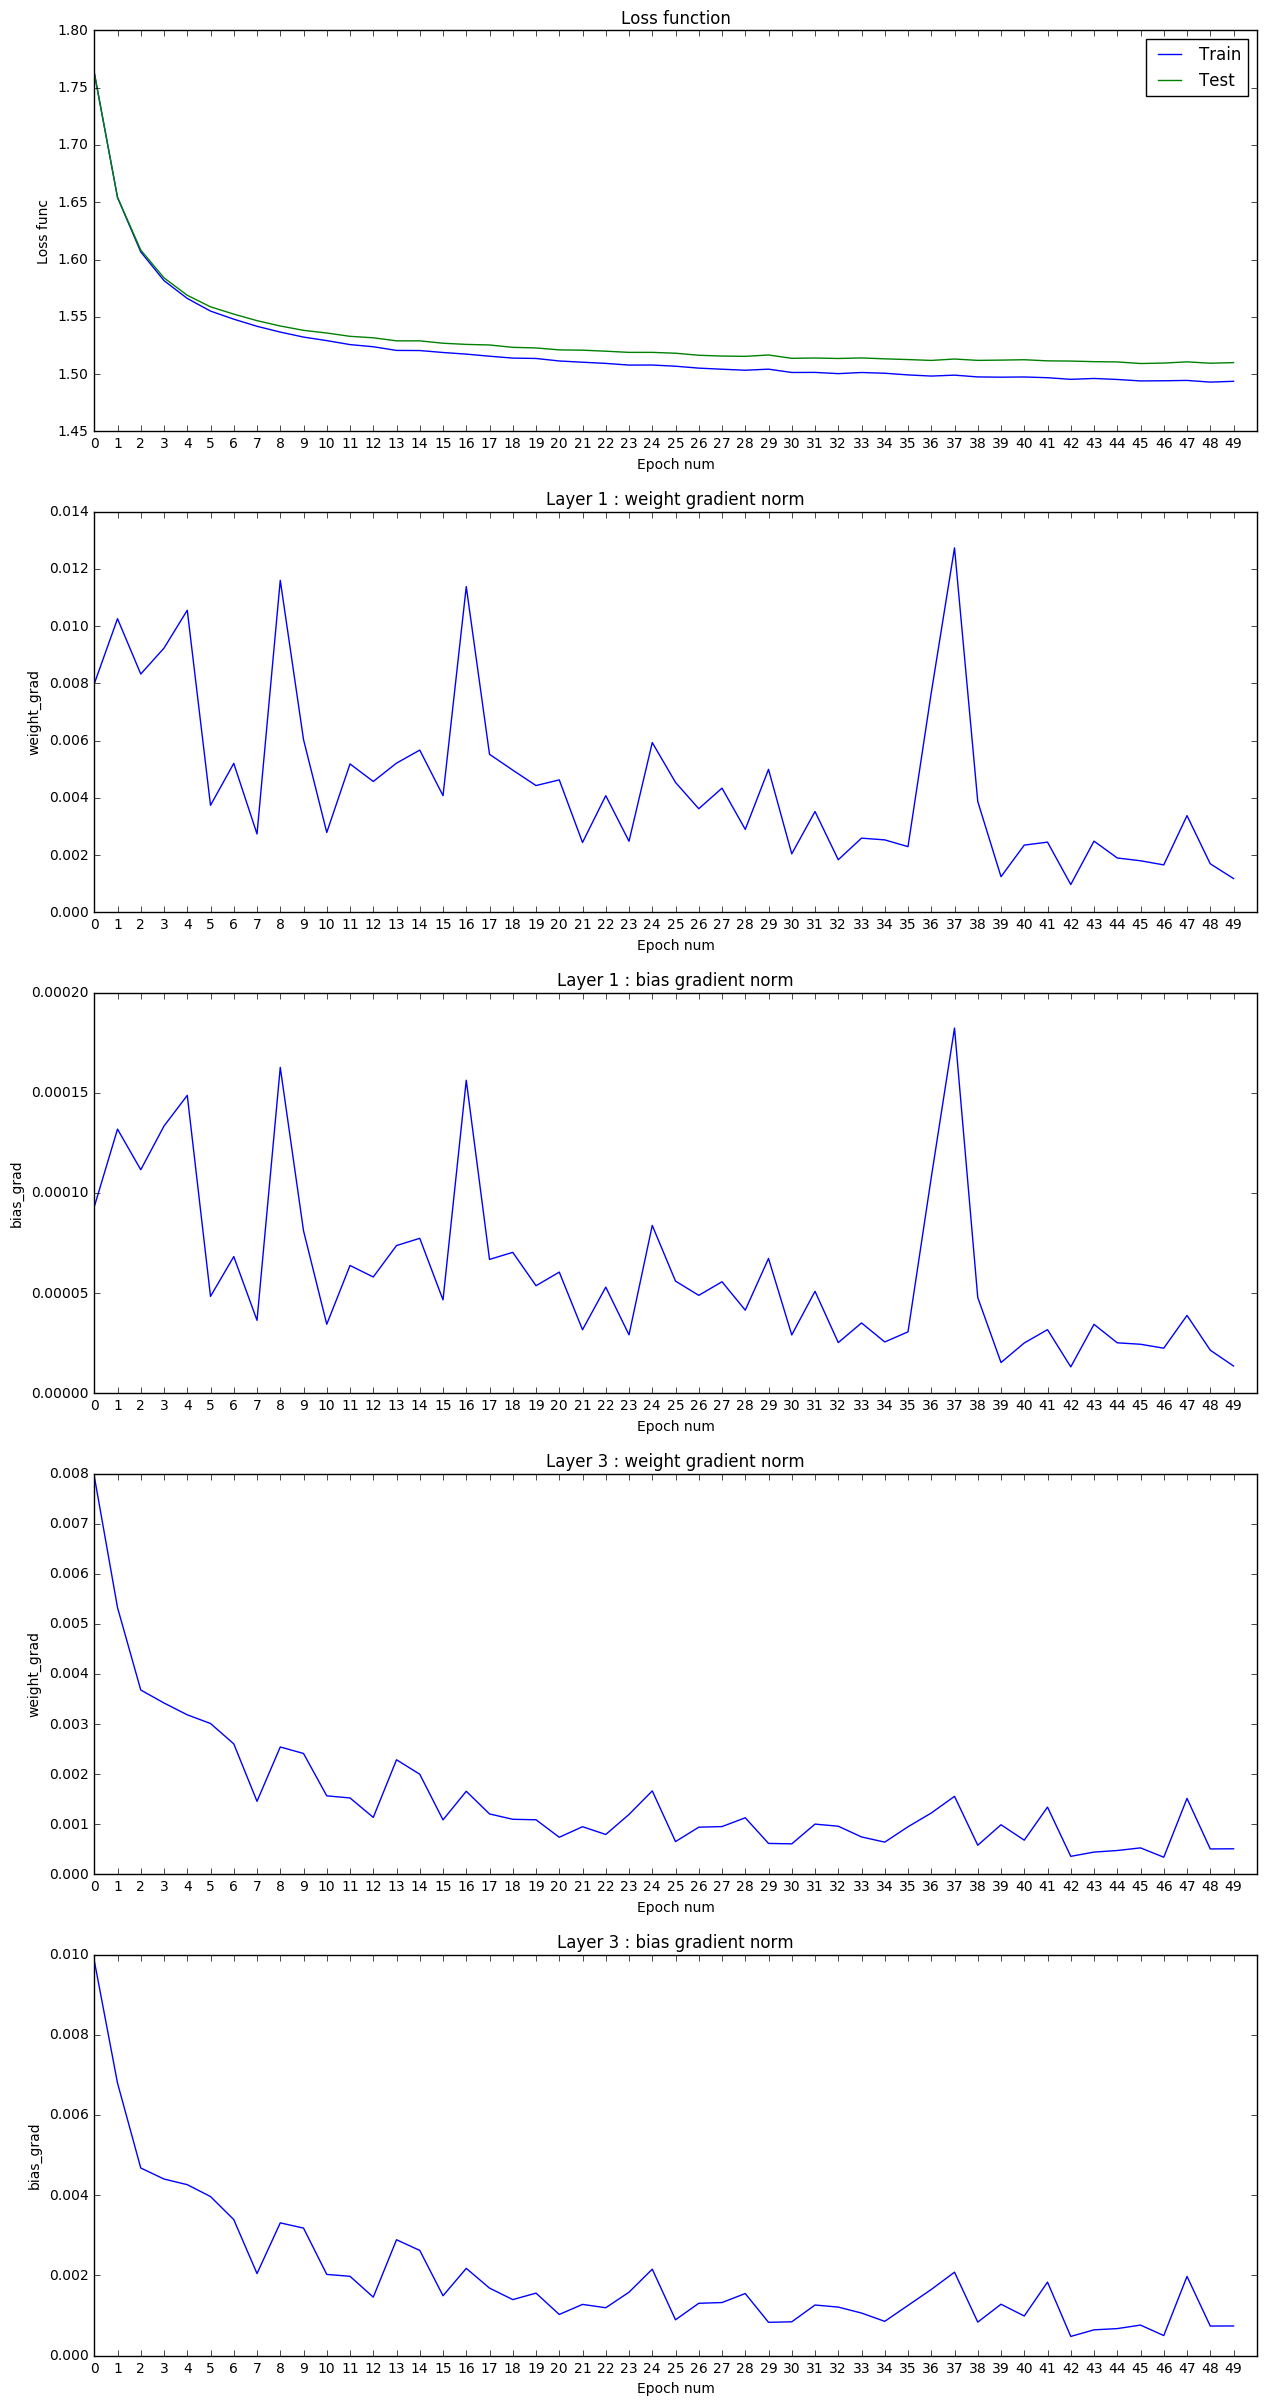

Train report
             precision    recall  f1-score   support

          0       0.98      0.99      0.98      4674
          1       0.98      0.99      0.99      5334
          2       0.97      0.95      0.96      4669
          3       0.96      0.95      0.95      4822
          4       0.95      0.98      0.97      4571
          5       0.96      0.95      0.96      4146
          6       0.98      0.98      0.98      4553
          7       0.97      0.98      0.97      4867
          8       0.96      0.96      0.96      4552
          9       0.97      0.95      0.96      4712

avg / total       0.97      0.97      0.97     46900

Test report
             precision    recall  f1-score   support

          0       0.97      0.97      0.97      2229
          1       0.98      0.98      0.98      2543
          2       0.95      0.93      0.94      2321
          3       0.93      0.94      0.93      2319
          4       0.93      0.97      0.95      2253
          5      

In [203]:
D_in = 784
D_out = 10
D_deep = 100 
model = torch.nn.Sequential(
          torch.nn.Linear(D_in, D_deep),
          torch.nn.Sigmoid(),
          torch.nn.Linear(D_deep, D_out),
          torch.nn.Sigmoid(),
          torch.nn.LogSoftmax()
)
loss_fn = torch.nn.NLLLoss(size_average=True)


learning_rate = 1e-4

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


loss_arr, layer_arr, test_loss_arr = learn_on_model(X_TRAIN, Y_TRAIN, model, loss_fn, X_TEST,\
                                                    Y_TEST,\
                                                    learning_rate, epoch_temp = 1000, temp_change = 1,\
                                                    max_epoch_num=50, batch_size = 32)

draw_plots(model, loss_arr, layer_arr, test_loss_arr)
make_classification_report(model, X_TRAIN, Y_TRAIN, X_TEST, Y_TEST)

Улучшилось. Попробуем и с уменьшенным 

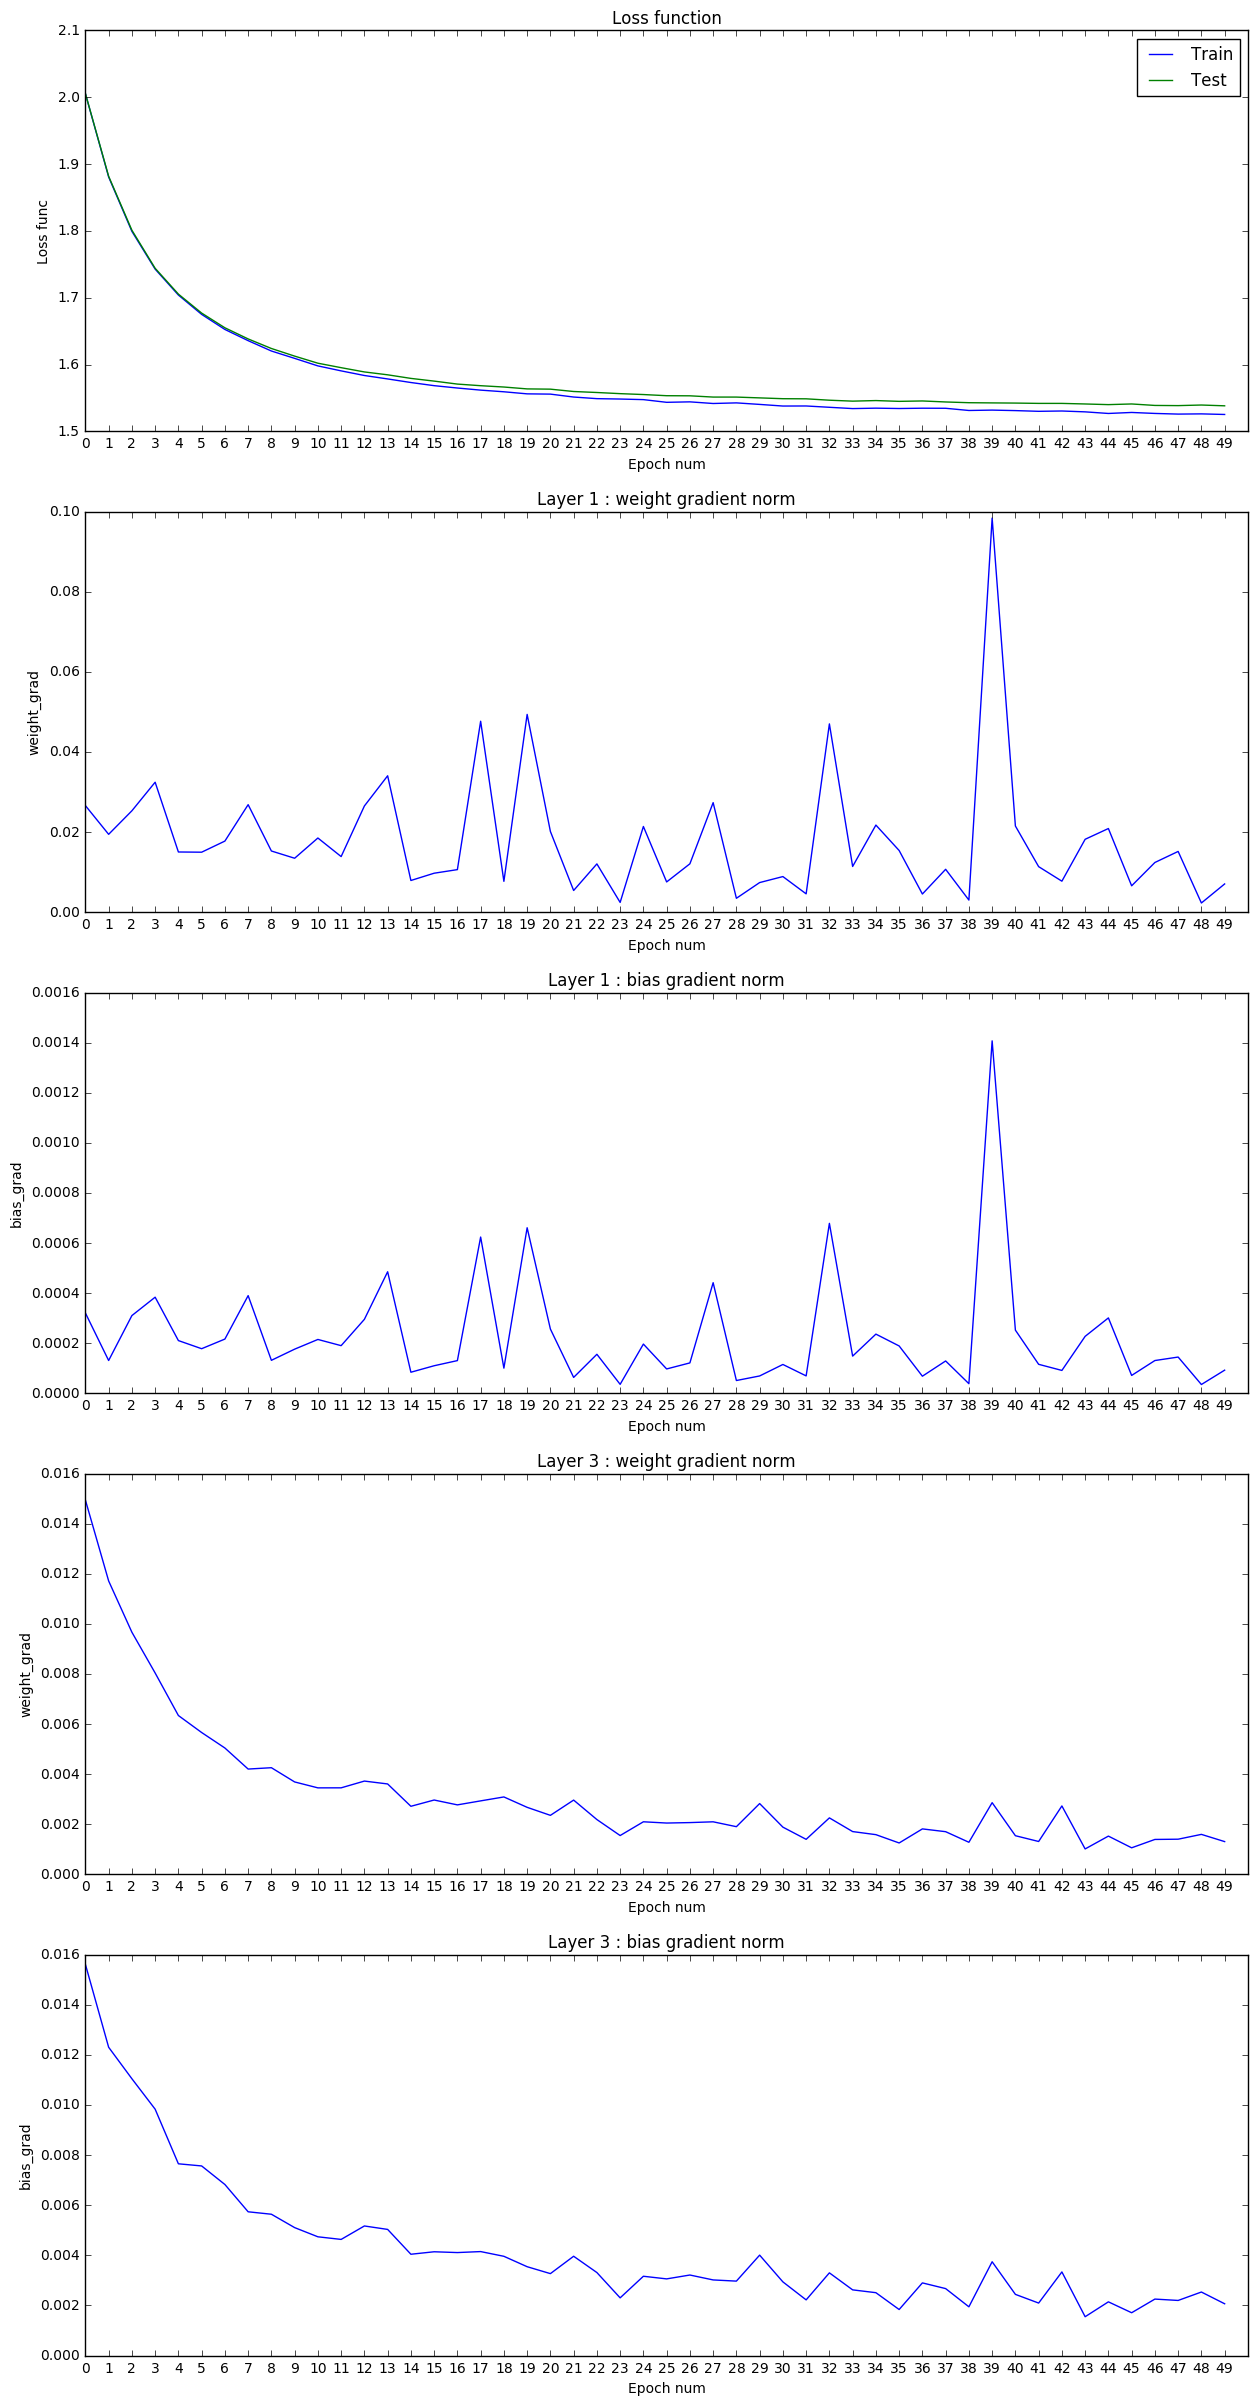

Train report
             precision    recall  f1-score   support

          0       0.95      0.98      0.97      4674
          1       0.97      0.97      0.97      5334
          2       0.95      0.93      0.94      4669
          3       0.93      0.92      0.92      4822
          4       0.92      0.96      0.94      4571
          5       0.92      0.91      0.91      4146
          6       0.95      0.96      0.96      4553
          7       0.96      0.94      0.95      4867
          8       0.91      0.91      0.91      4552
          9       0.93      0.92      0.93      4712

avg / total       0.94      0.94      0.94     46900

Test report
             precision    recall  f1-score   support

          0       0.95      0.96      0.95      2229
          1       0.97      0.97      0.97      2543
          2       0.93      0.90      0.92      2321
          3       0.90      0.91      0.90      2319
          4       0.90      0.94      0.92      2253
          5      

In [204]:
D_in = 784
D_out = 10
D_deep = 25 
model = torch.nn.Sequential(
          torch.nn.Linear(D_in, D_deep),
          torch.nn.Sigmoid(),
          torch.nn.Linear(D_deep, D_out),
          torch.nn.Sigmoid(),
          torch.nn.LogSoftmax()
)
loss_fn = torch.nn.NLLLoss(size_average=True)


learning_rate = 1e-4

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


loss_arr, layer_arr, test_loss_arr = learn_on_model(X_TRAIN, Y_TRAIN, model, loss_fn, X_TEST,\
                                                    Y_TEST,\
                                                    learning_rate, epoch_temp = 1000, temp_change = 1,\
                                                    max_epoch_num=50, batch_size = 32)

draw_plots(model, loss_arr, layer_arr, test_loss_arr)
make_classification_report(model, X_TRAIN, Y_TRAIN, X_TEST, Y_TEST)

Стало хуже. Значит оставляем равным 100. Уберем Sigmoid в конце

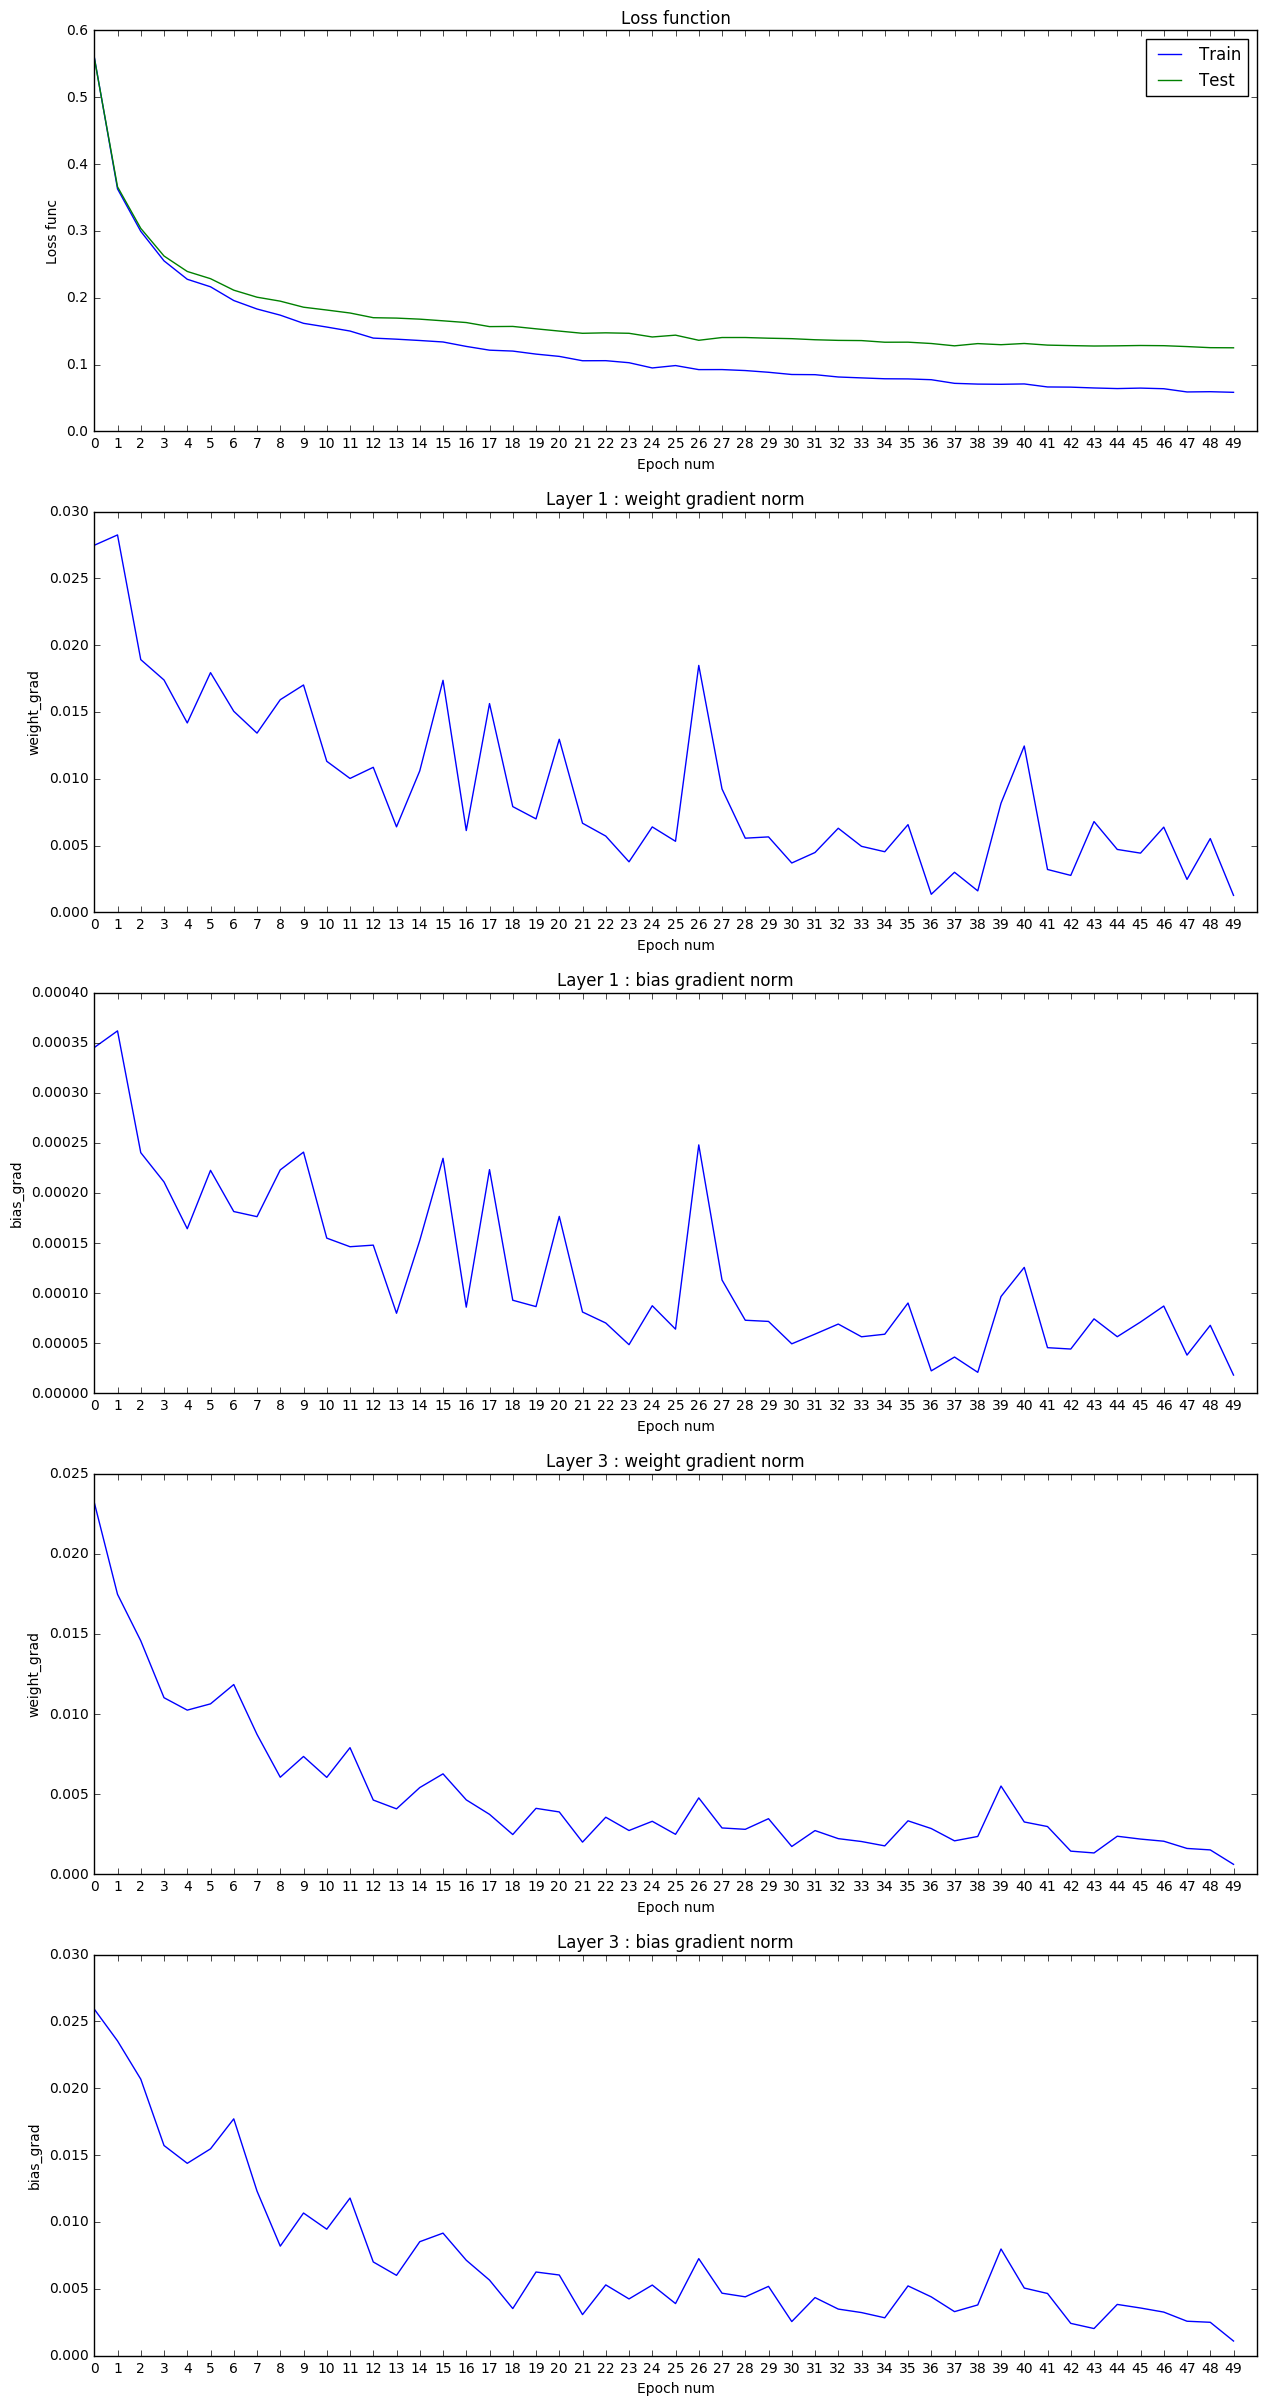

Train report
             precision    recall  f1-score   support

          0       0.99      0.99      0.99      4674
          1       0.99      0.99      0.99      5334
          2       0.99      0.98      0.98      4669
          3       0.98      0.97      0.98      4822
          4       0.98      0.99      0.98      4571
          5       0.98      0.98      0.98      4146
          6       0.98      0.99      0.99      4553
          7       0.99      0.99      0.99      4867
          8       0.98      0.98      0.98      4552
          9       0.98      0.98      0.98      4712

avg / total       0.98      0.98      0.98     46900

Test report
             precision    recall  f1-score   support

          0       0.98      0.98      0.98      2229
          1       0.98      0.98      0.98      2543
          2       0.97      0.95      0.96      2321
          3       0.94      0.96      0.95      2319
          4       0.95      0.97      0.96      2253
          5      

In [206]:
D_in = 784
D_out = 10
D_deep = 100 
model = torch.nn.Sequential(
          torch.nn.Linear(D_in, D_deep),
          torch.nn.Sigmoid(),
          torch.nn.Linear(D_deep, D_out),
          torch.nn.LogSoftmax()
)
loss_fn = torch.nn.NLLLoss(size_average=True)


learning_rate = 1e-4

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


loss_arr, layer_arr, test_loss_arr = learn_on_model(X_TRAIN, Y_TRAIN, model, loss_fn, X_TEST,\
                                                    Y_TEST,\
                                                    learning_rate, epoch_temp = 1000, temp_change = 1,\
                                                    max_epoch_num=50, batch_size = 32)

draw_plots(model, loss_arr, layer_arr, test_loss_arr)
make_classification_report(model, X_TRAIN, Y_TRAIN, X_TEST, Y_TEST)

Улучшилось!. Попробуем добавить еще один слой с тангенциальной функцией активации

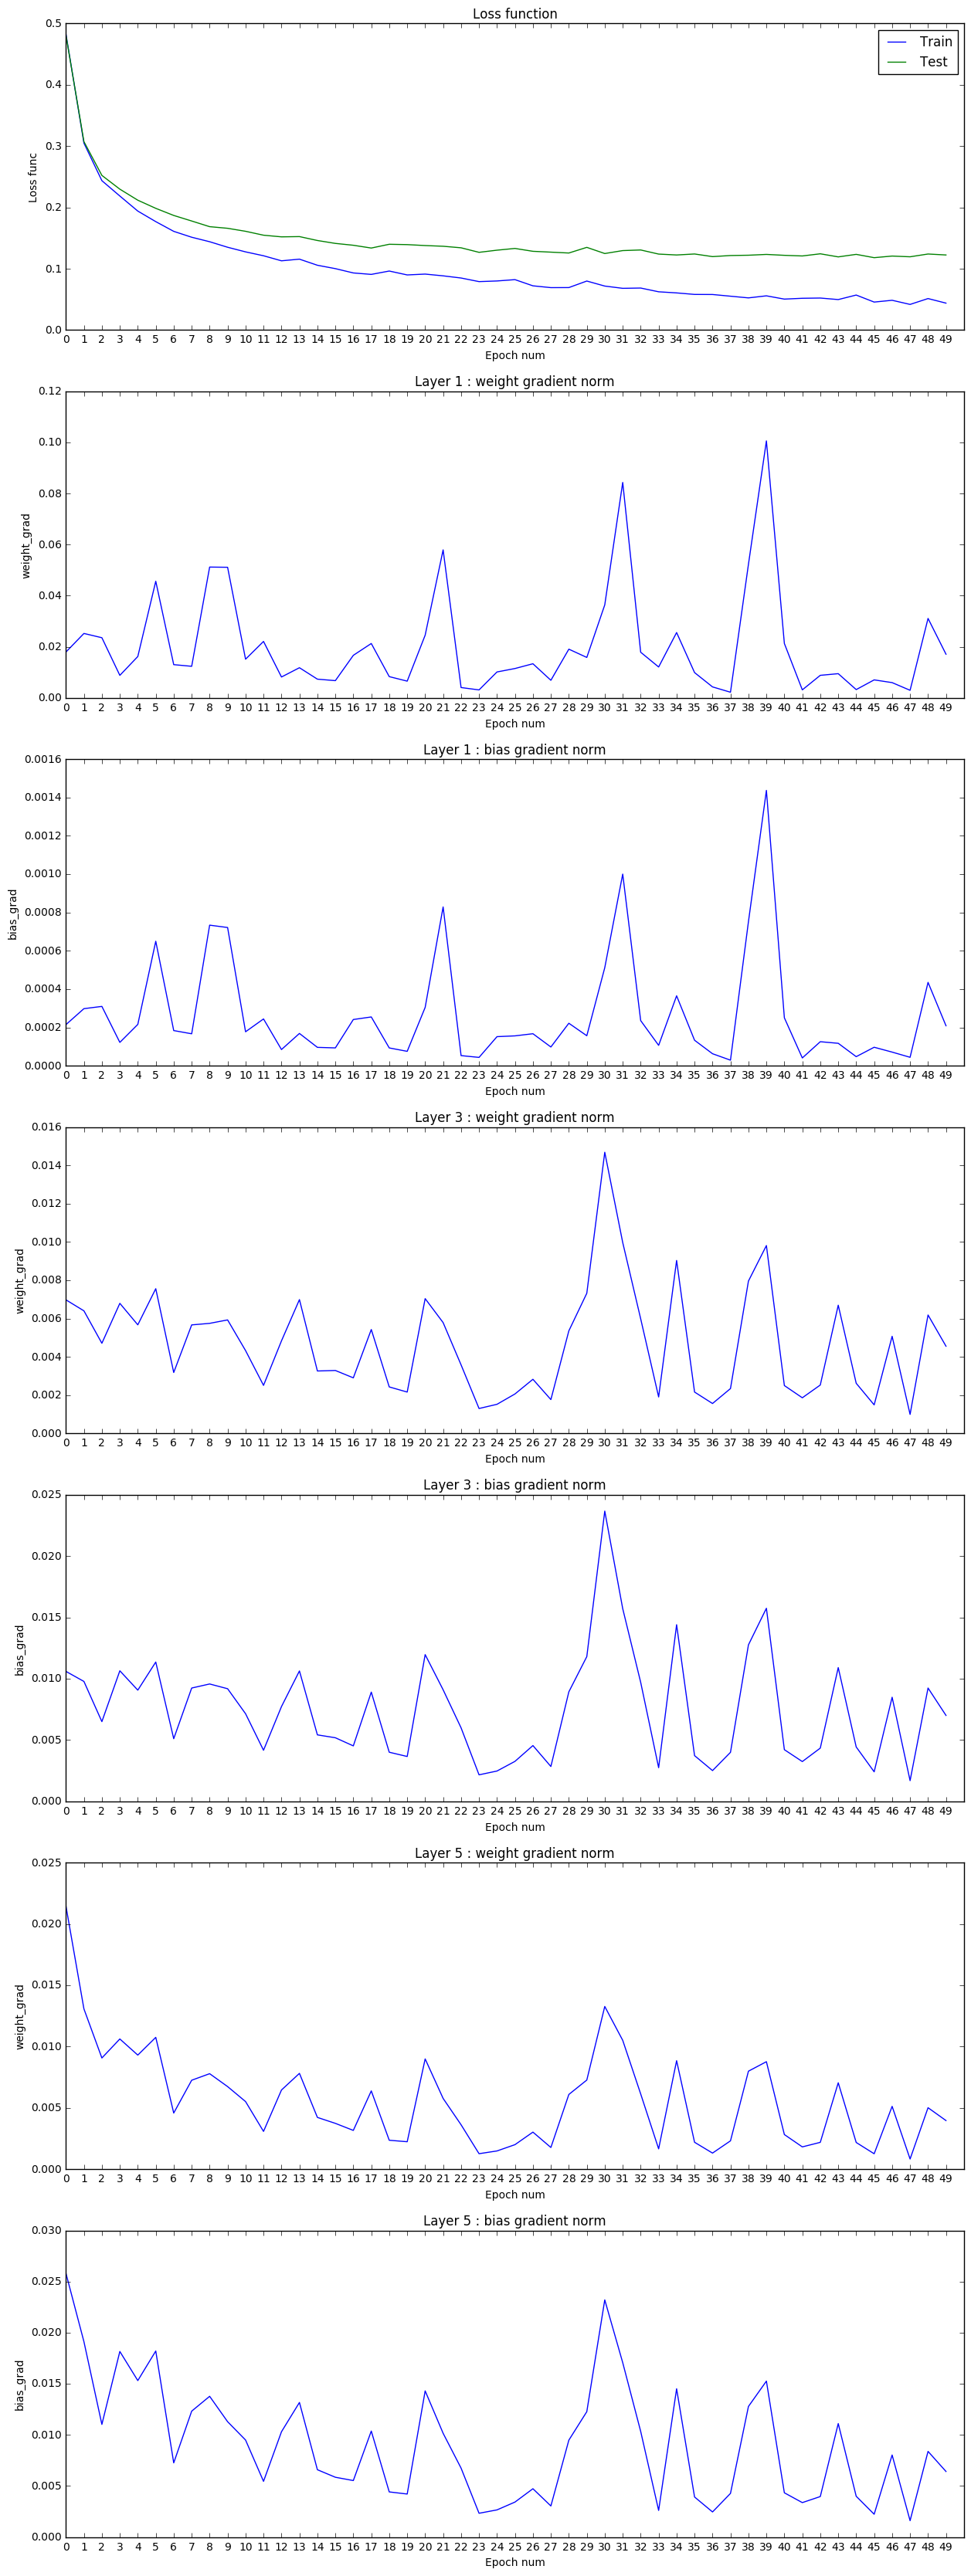

Train report
             precision    recall  f1-score   support

          0       0.99      0.99      0.99      4674
          1       1.00      0.99      0.99      5334
          2       0.99      0.98      0.98      4669
          3       0.98      0.99      0.98      4822
          4       0.98      0.99      0.99      4571
          5       0.98      0.99      0.99      4146
          6       0.99      0.99      0.99      4553
          7       0.99      0.99      0.99      4867
          8       0.98      0.99      0.98      4552
          9       0.99      0.97      0.98      4712

avg / total       0.99      0.99      0.99     46900

Test report
             precision    recall  f1-score   support

          0       0.98      0.98      0.98      2229
          1       0.99      0.98      0.98      2543
          2       0.97      0.95      0.96      2321
          3       0.94      0.96      0.95      2319
          4       0.96      0.97      0.97      2253
          5      

In [207]:
D_in = 784
D_out = 10
D_deep1 = 100
D_deep2 = 50
model = torch.nn.Sequential(
          torch.nn.Linear(D_in, D_deep1),
          torch.nn.Sigmoid(),
          torch.nn.Linear(D_deep1, D_deep2),
          torch.nn.Tanh(),
          torch.nn.Linear(D_deep2, D_out),
          torch.nn.LogSoftmax()
)
loss_fn = torch.nn.NLLLoss(size_average=True)


learning_rate = 1e-4

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


loss_arr, layer_arr, test_loss_arr = learn_on_model(X_TRAIN, Y_TRAIN, model, loss_fn, X_TEST,\
                                                    Y_TEST,\
                                                    learning_rate, epoch_temp = 1000, temp_change = 1,\
                                                    max_epoch_num=50, batch_size = 32)

draw_plots(model, loss_arr, layer_arr, test_loss_arr)
make_classification_report(model, X_TRAIN, Y_TRAIN, X_TEST, Y_TEST)

Не ухудшилось . Но видно, что мы стали переобучаться. Попробуем добавить еще один слой с функцией LeakyReLU

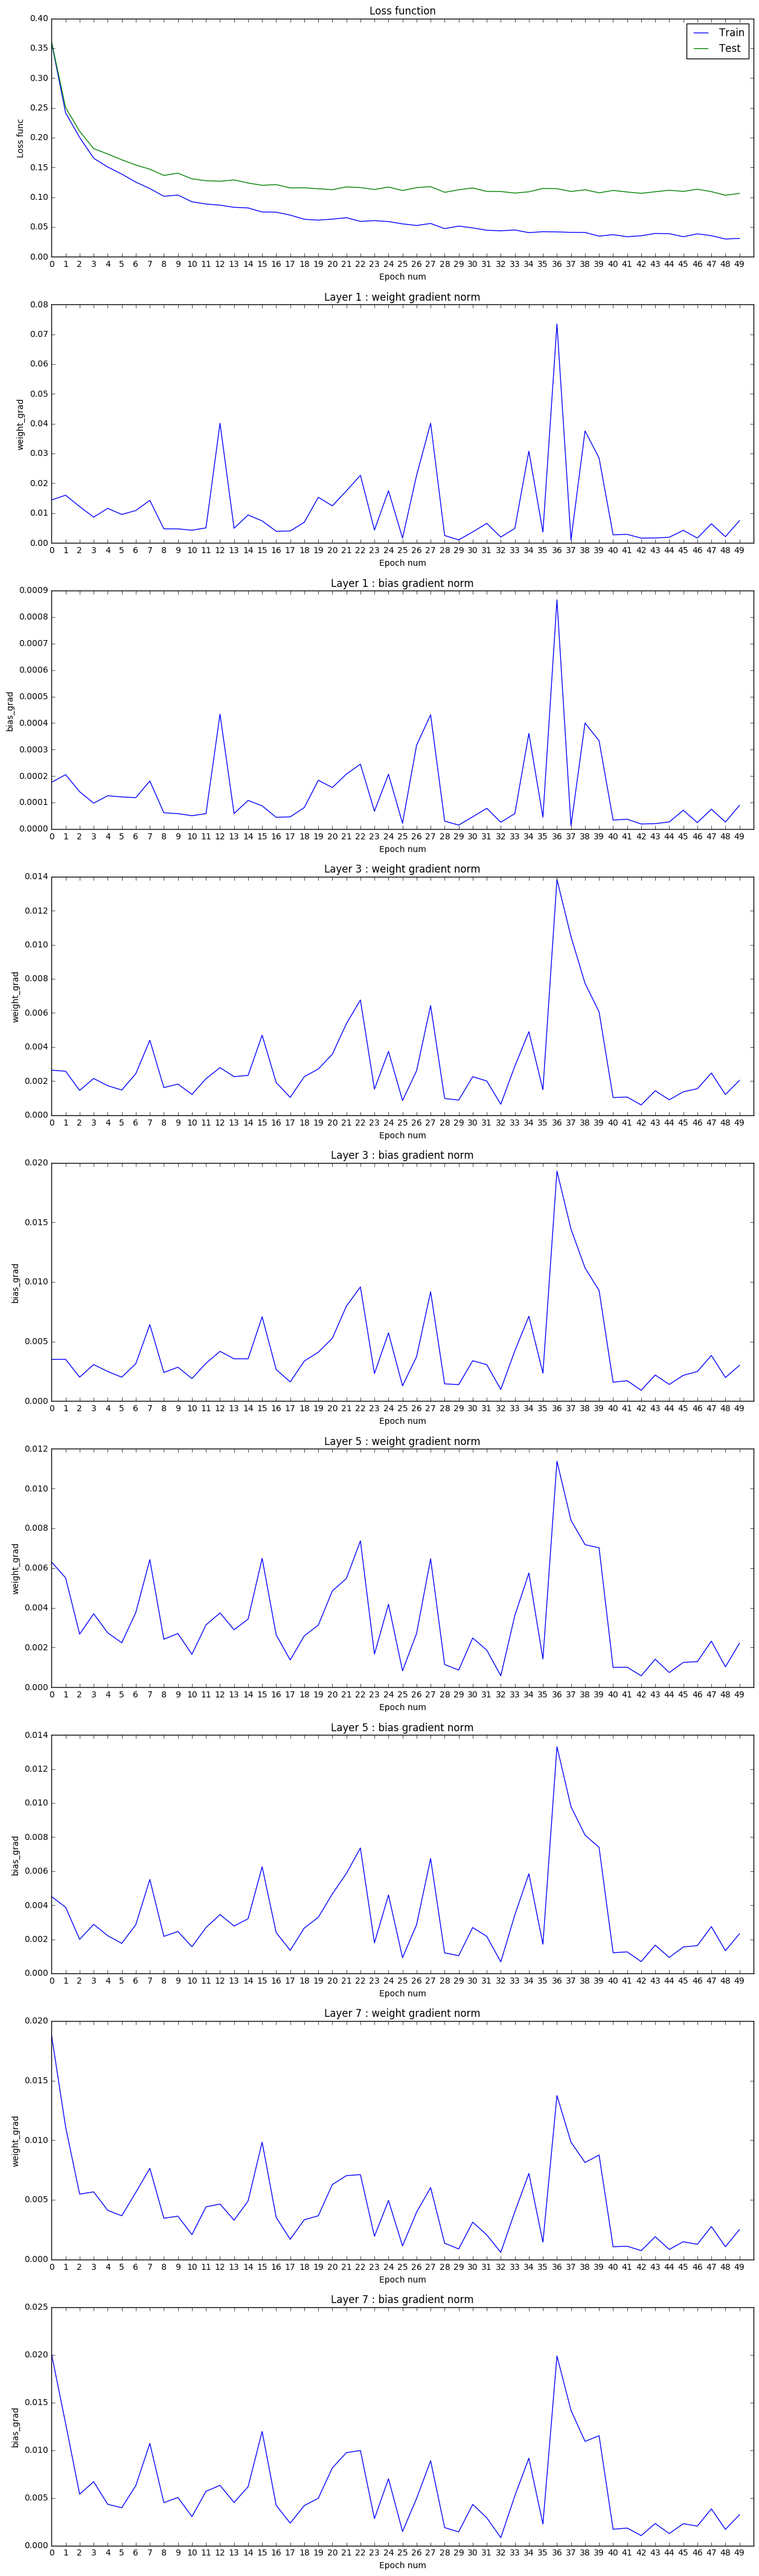

Train report
             precision    recall  f1-score   support

          0       0.99      1.00      0.99      4674
          1       1.00      1.00      1.00      5334
          2       1.00      0.99      0.99      4669
          3       0.98      0.99      0.99      4822
          4       0.99      0.98      0.99      4571
          5       0.99      0.99      0.99      4146
          6       0.99      0.99      0.99      4553
          7       0.99      0.99      0.99      4867
          8       0.99      0.98      0.99      4552
          9       0.98      0.99      0.98      4712

avg / total       0.99      0.99      0.99     46900

Test report
             precision    recall  f1-score   support

          0       0.98      0.98      0.98      2229
          1       0.98      0.98      0.98      2543
          2       0.97      0.97      0.97      2321
          3       0.95      0.97      0.96      2319
          4       0.98      0.96      0.97      2253
          5      

In [210]:
D_in = 784
D_out = 10
D_deep1 = 200
D_deep2 = 100
D_deep3 = 50 
model = torch.nn.Sequential(
    
          torch.nn.Linear(D_in, D_deep1),
          torch.nn.Sigmoid(),
          torch.nn.Linear(D_deep1, D_deep2),
          torch.nn.LeakyReLU(),
          torch.nn.Linear(D_deep2, D_deep3),
          torch.nn.Tanh(),
          torch.nn.Linear(D_deep3, D_out),
          torch.nn.LogSoftmax()
)
loss_fn = torch.nn.NLLLoss(size_average=True)


learning_rate = 1e-4

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


loss_arr, layer_arr, test_loss_arr = learn_on_model(X_TRAIN, Y_TRAIN, model, loss_fn, X_TEST,\
                                                    Y_TEST,\
                                                    learning_rate, epoch_temp = 1000, temp_change = 1,\
                                                    max_epoch_num=50, batch_size = 32)

draw_plots(model, loss_arr, layer_arr, test_loss_arr)
make_classification_report(model, X_TRAIN, Y_TRAIN, X_TEST, Y_TEST)

Переобучаемся, но улучшение есть. Хотя исполнение заняло значительно больше времени. Попробуем добавить еще один слой

Execution take 1082.820364


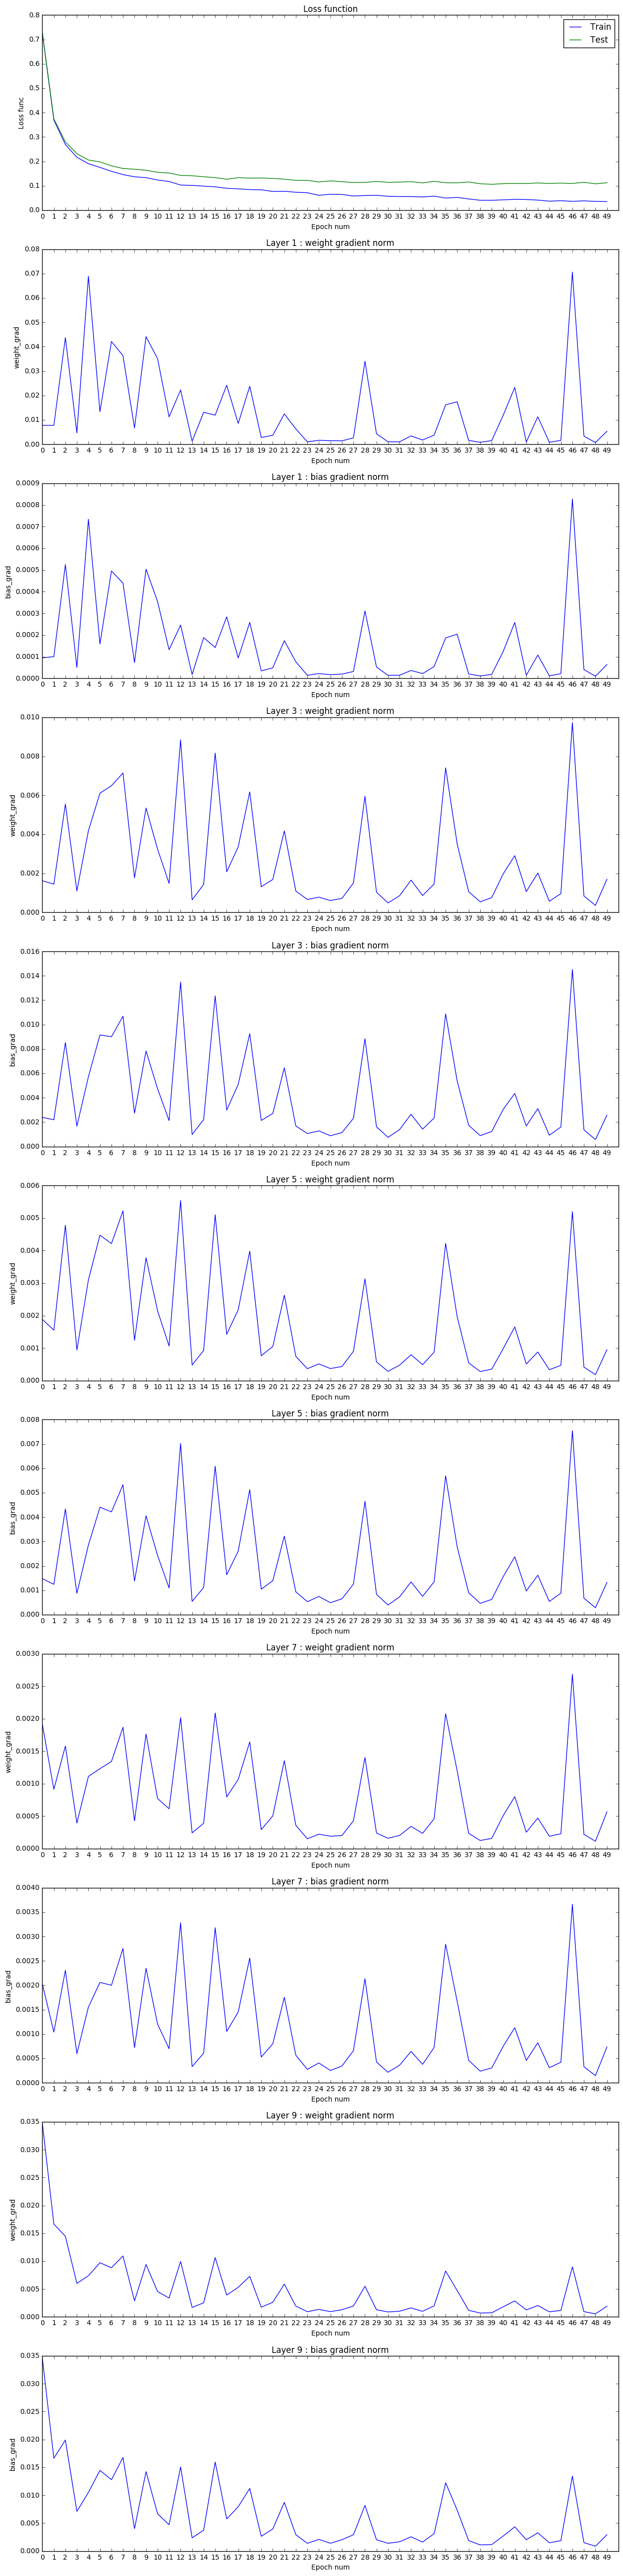

Train report
             precision    recall  f1-score   support

          0       1.00      0.99      0.99      4674
          1       0.99      1.00      1.00      5334
          2       0.99      0.99      0.99      4669
          3       0.97      0.99      0.98      4822
          4       0.99      0.99      0.99      4571
          5       1.00      0.98      0.99      4146
          6       0.99      0.99      0.99      4553
          7       0.99      0.99      0.99      4867
          8       0.98      0.99      0.98      4552
          9       0.99      0.98      0.98      4712

avg / total       0.99      0.99      0.99     46900

Test report
             precision    recall  f1-score   support

          0       0.98      0.98      0.98      2229
          1       0.99      0.99      0.99      2543
          2       0.97      0.97      0.97      2321
          3       0.94      0.97      0.95      2319
          4       0.97      0.97      0.97      2253
          5      

In [220]:
D_in = 784
D_out = 10
D_deep1 = 250
D_deep2 = 150
D_deep3 = 100
D_deep4 = 50

model = torch.nn.Sequential(
    
          torch.nn.Linear(D_in, D_deep1),
          torch.nn.Sigmoid(),
          torch.nn.Linear(D_deep1, D_deep2),
          torch.nn.LeakyReLU(),
          torch.nn.Linear(D_deep2, D_deep3),
          torch.nn.Tanh(),
          torch.nn.Linear(D_deep3, D_deep4),
          torch.nn.Sigmoid(),
          torch.nn.Linear(D_deep4, D_out),
          torch.nn.LogSoftmax()
)
loss_fn = torch.nn.NLLLoss(size_average=True)


learning_rate = 1e-4

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


loss_arr, layer_arr, test_loss_arr = learn_on_model(X_TRAIN, Y_TRAIN, model, loss_fn, X_TEST,\
                                                    Y_TEST,\
                                                    learning_rate, epoch_temp = 1000, temp_change = 1,\
                                                    max_epoch_num=50, batch_size = 32)

draw_plots(model, loss_arr, layer_arr, test_loss_arr)
make_classification_report(model, X_TRAIN, Y_TRAIN, X_TEST, Y_TEST)

Слишком долго обучаемся. Оптимальной можно считать структуру с одним скрытым слоем. Попробуем изменить в ней функцию активации 

Execution take 291.017691135


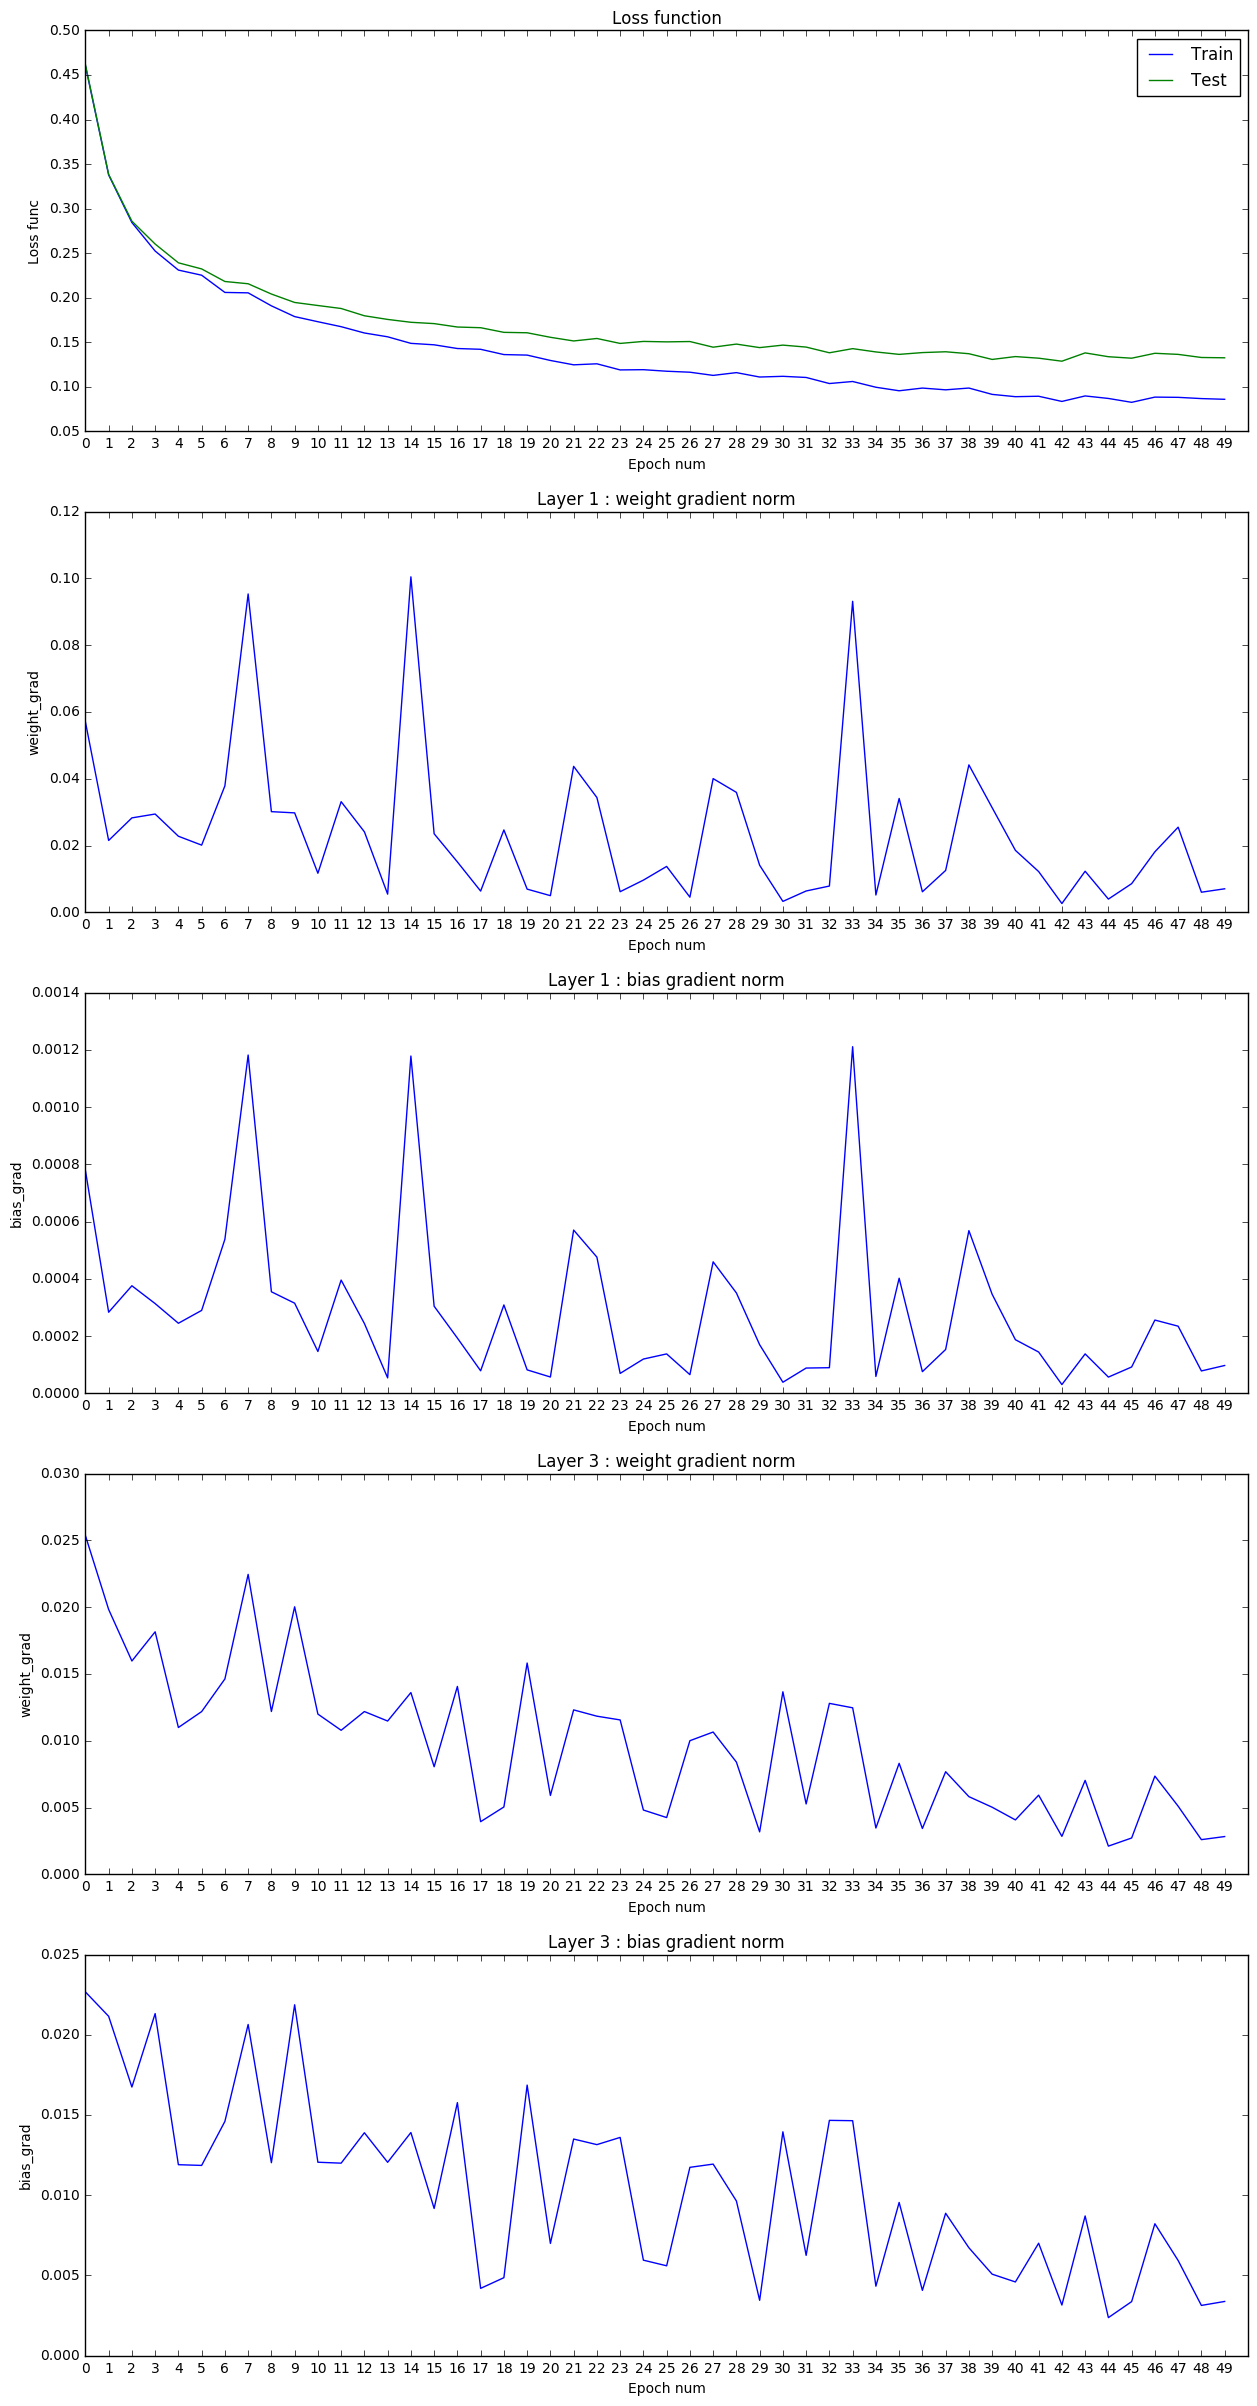

Train report
             precision    recall  f1-score   support

          0       0.98      0.98      0.98      4674
          1       0.98      0.99      0.99      5334
          2       0.97      0.97      0.97      4669
          3       0.97      0.97      0.97      4822
          4       0.97      0.97      0.97      4571
          5       0.97      0.96      0.97      4146
          6       0.99      0.98      0.98      4553
          7       0.98      0.98      0.98      4867
          8       0.96      0.97      0.96      4552
          9       0.96      0.97      0.97      4712

avg / total       0.97      0.97      0.97     46900

Test report
             precision    recall  f1-score   support

          0       0.98      0.97      0.97      2229
          1       0.98      0.99      0.98      2543
          2       0.96      0.96      0.96      2321
          3       0.94      0.96      0.95      2319
          4       0.96      0.96      0.96      2253
          5      

In [221]:
D_in = 784
D_out = 10
D_deep = 100 
model = torch.nn.Sequential(
          torch.nn.Linear(D_in, D_deep),
          torch.nn.Tanh(),
          torch.nn.Linear(D_deep, D_out),
          torch.nn.LogSoftmax()
)
loss_fn = torch.nn.NLLLoss(size_average=True)


learning_rate = 1e-4

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


loss_arr, layer_arr, test_loss_arr = learn_on_model(X_TRAIN, Y_TRAIN, model, loss_fn, X_TEST,\
                                                    Y_TEST,\
                                                    learning_rate, epoch_temp = 1000, temp_change = 1,\
                                                    max_epoch_num=50, batch_size = 32)

draw_plots(model, loss_arr, layer_arr, test_loss_arr)
make_classification_report(model, X_TRAIN, Y_TRAIN, X_TEST, Y_TEST)

Попробуем также убрать из линейных слоев bias

Execution take 278.601896048


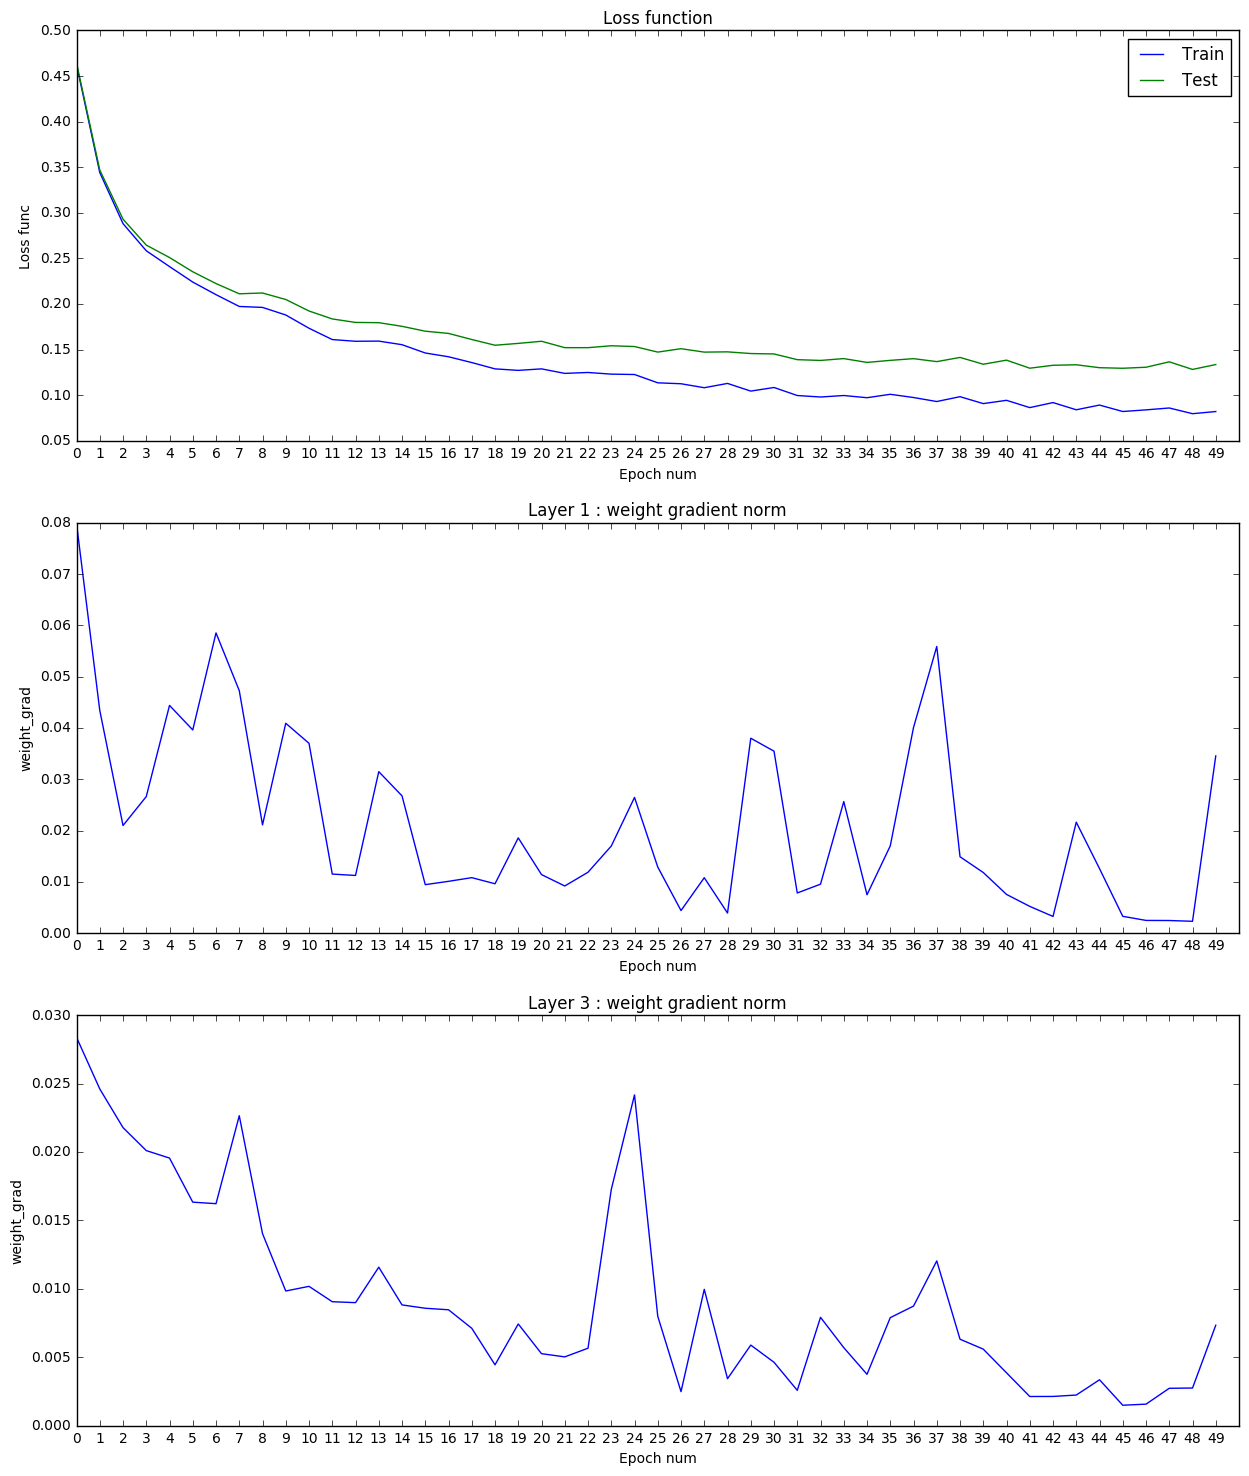

Train report
             precision    recall  f1-score   support

          0       0.99      0.98      0.99      4674
          1       0.99      0.99      0.99      5334
          2       0.98      0.97      0.98      4669
          3       0.95      0.98      0.97      4822
          4       0.98      0.97      0.97      4571
          5       0.97      0.97      0.97      4146
          6       0.99      0.98      0.98      4553
          7       0.98      0.98      0.98      4867
          8       0.96      0.96      0.96      4552
          9       0.96      0.97      0.97      4712

avg / total       0.98      0.98      0.98     46900

Test report
             precision    recall  f1-score   support

          0       0.98      0.97      0.98      2229
          1       0.98      0.98      0.98      2543
          2       0.95      0.96      0.96      2321
          3       0.93      0.96      0.95      2319
          4       0.96      0.96      0.96      2253
          5      

In [223]:
D_in = 784
D_out = 10
D_deep = 100 
model = torch.nn.Sequential(
          torch.nn.Linear(D_in, D_deep, bias = False),
          torch.nn.Tanh(),
          torch.nn.Linear(D_deep, D_out,  bias = False),
          torch.nn.LogSoftmax()
)
loss_fn = torch.nn.NLLLoss(size_average=True)


learning_rate = 1e-4

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


loss_arr, layer_arr, test_loss_arr = learn_on_model(X_TRAIN, Y_TRAIN, model, loss_fn, X_TEST,\
                                                    Y_TEST,\
                                                    learning_rate, epoch_temp = 1000, temp_change = 1,\
                                                    max_epoch_num=50, batch_size = 32)

draw_plots(model, loss_arr, layer_arr, test_loss_arr)
make_classification_report(model, X_TRAIN, Y_TRAIN, X_TEST, Y_TEST)

Значимых различий нет. И попробуем вариант с  двумя скрытыми слоями, у которых один из линейных слоев не будет иметь bias

Execution take 294.628899097


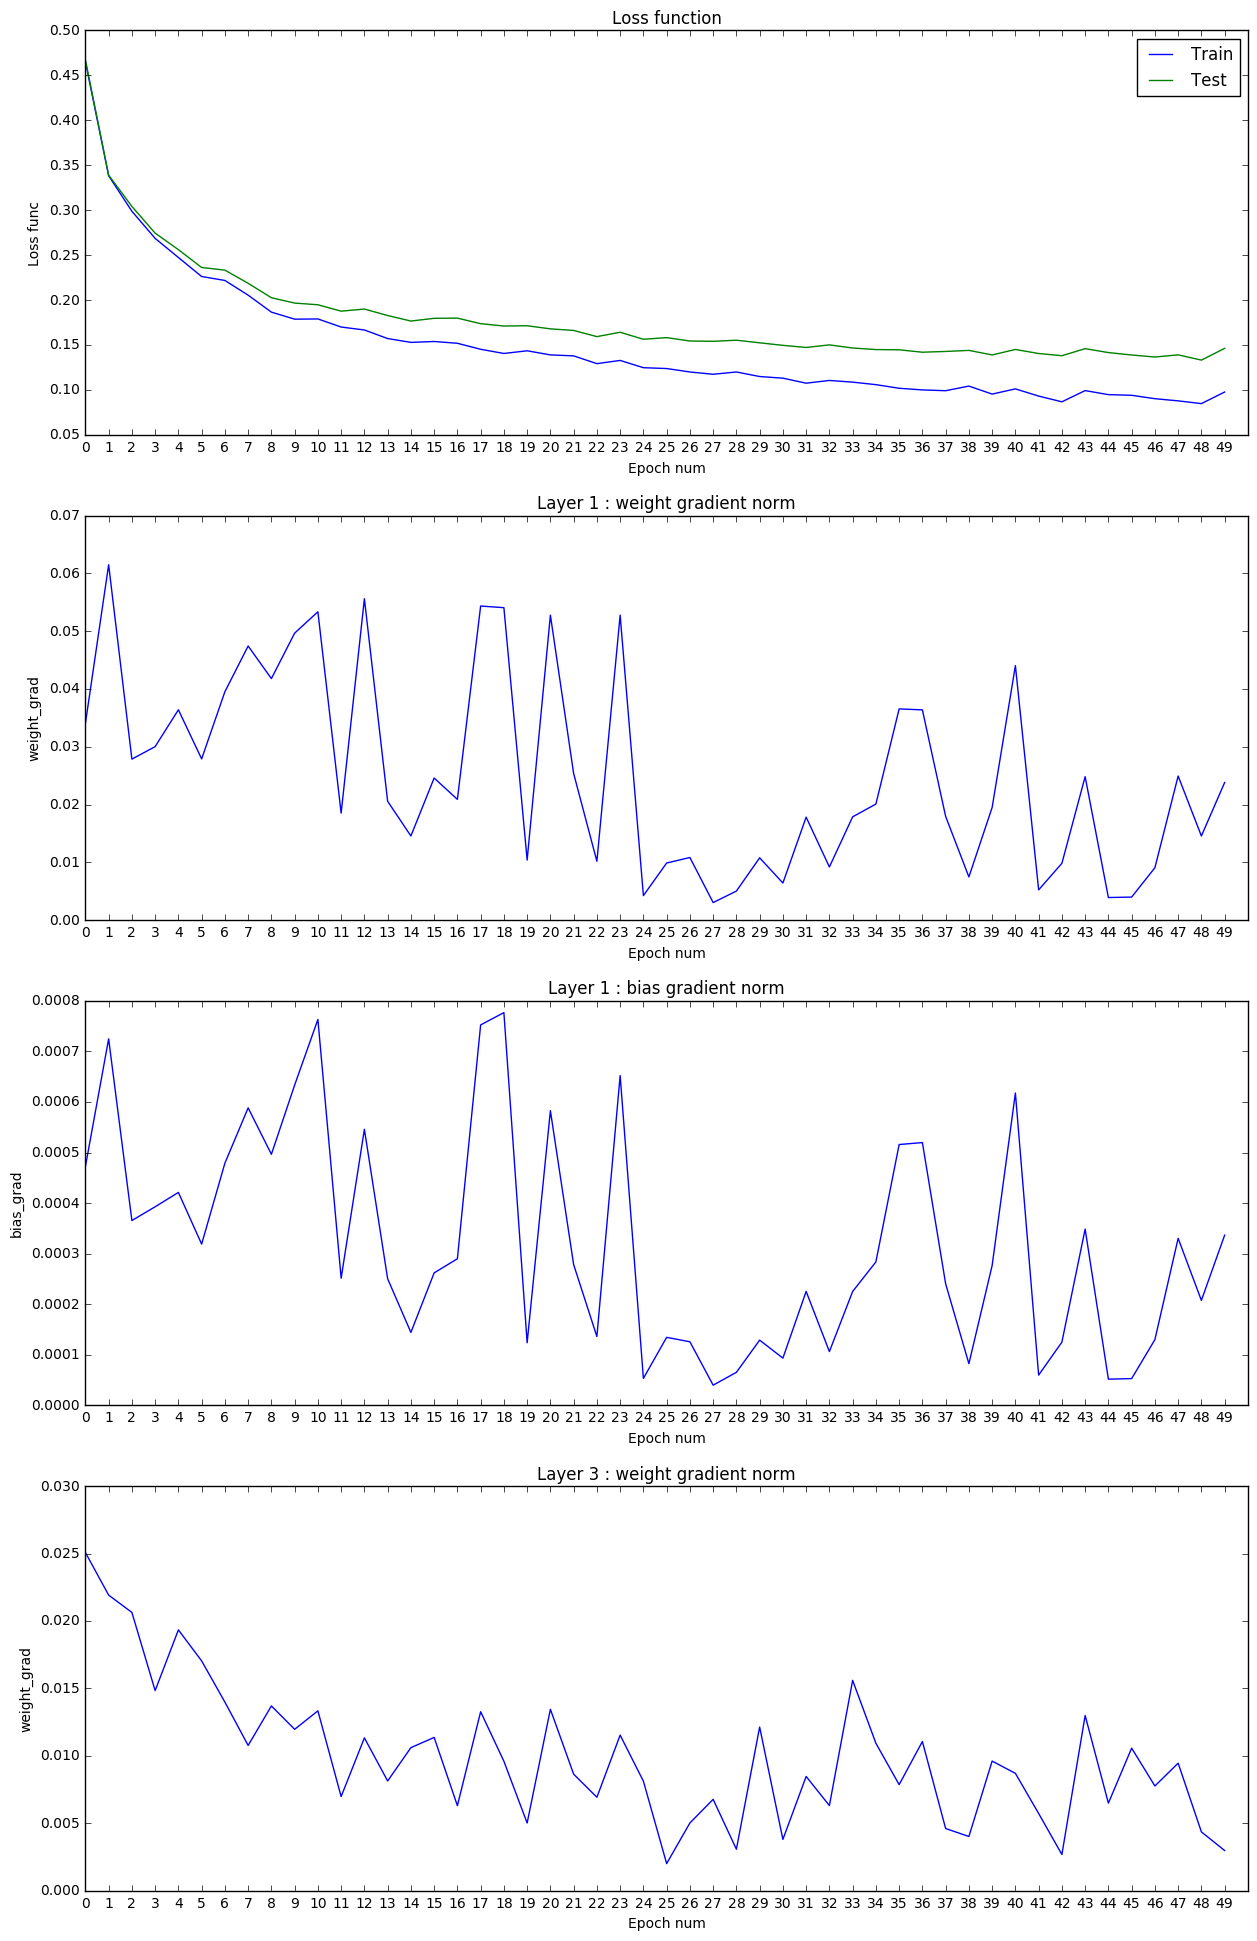

Train report
             precision    recall  f1-score   support

          0       0.99      0.98      0.99      4674
          1       0.99      0.99      0.99      5334
          2       0.98      0.97      0.97      4669
          3       0.95      0.97      0.96      4822
          4       0.96      0.97      0.97      4571
          5       0.96      0.97      0.96      4146
          6       0.98      0.97      0.98      4553
          7       0.96      0.98      0.97      4867
          8       0.95      0.97      0.96      4552
          9       0.97      0.94      0.95      4712

avg / total       0.97      0.97      0.97     46900

Test report
             precision    recall  f1-score   support

          0       0.98      0.97      0.97      2229
          1       0.99      0.98      0.99      2543
          2       0.97      0.96      0.96      2321
          3       0.93      0.96      0.94      2319
          4       0.96      0.96      0.96      2253
          5      

In [224]:
D_in = 784
D_out = 10
D_deep = 100 
model = torch.nn.Sequential(
          torch.nn.Linear(D_in, D_deep, bias = True),
          torch.nn.Tanh(),
          torch.nn.Linear(D_deep, D_out,  bias = False),
          torch.nn.LogSoftmax()
)
loss_fn = torch.nn.NLLLoss(size_average=True)


learning_rate = 1e-4

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


loss_arr, layer_arr, test_loss_arr = learn_on_model(X_TRAIN, Y_TRAIN, model, loss_fn, X_TEST,\
                                                    Y_TEST,\
                                                    learning_rate, epoch_temp = 1000, temp_change = 1,\
                                                    max_epoch_num=50, batch_size = 32)

draw_plots(model, loss_arr, layer_arr, test_loss_arr)
make_classification_report(model, X_TRAIN, Y_TRAIN, X_TEST, Y_TEST)

Качественного изменения все равно нет. Теперь попробуем изменить метки Y так, чтобы было разумно использовать MSE loss

In [284]:
X_FULL = mnist.data 
Y_FULL = mnist.target

In [285]:
X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(
      X_FULL, Y_FULL, test_size=0.33)

In [286]:
Y_TRAIN_MOD = np.zeros((Y_TRAIN.shape[0], 10))
for i in xrange(Y_TRAIN.shape[0]):
    Y_TRAIN_MOD[i] = np.zeros(10)
    Y_TRAIN_MOD[i][int(Y_TRAIN[i])] = 1
    
Y_TEST_MOD = np.zeros((Y_TEST.shape[0], 10))
for i in xrange(Y_TEST.shape[0]):
    Y_TEST_MOD[i] = np.zeros(10)
    Y_TEST_MOD[i][int(Y_TEST[i])] = 1

In [287]:
dtype = torch.FloatTensor
X_TRAIN = Variable(torch.from_numpy(X_TRAIN).type(dtype), requires_grad=False)
Y_TRAIN = Variable(torch.from_numpy(Y_TRAIN).type(dtype), requires_grad=False)
X_TEST = Variable(torch.from_numpy(X_TEST).type(dtype), requires_grad=False)
Y_TEST = Variable(torch.from_numpy(Y_TEST).type(dtype), requires_grad=False)
Y_TEST_MOD = Variable(torch.from_numpy(Y_TEST_MOD).type(dtype), requires_grad=False)
Y_TRAIN_MOD = Variable(torch.from_numpy(Y_TRAIN_MOD).type(dtype), requires_grad=False)

Попробуем немного измененную версию сети с оценкой MSE. 

Execution take 256.811470032


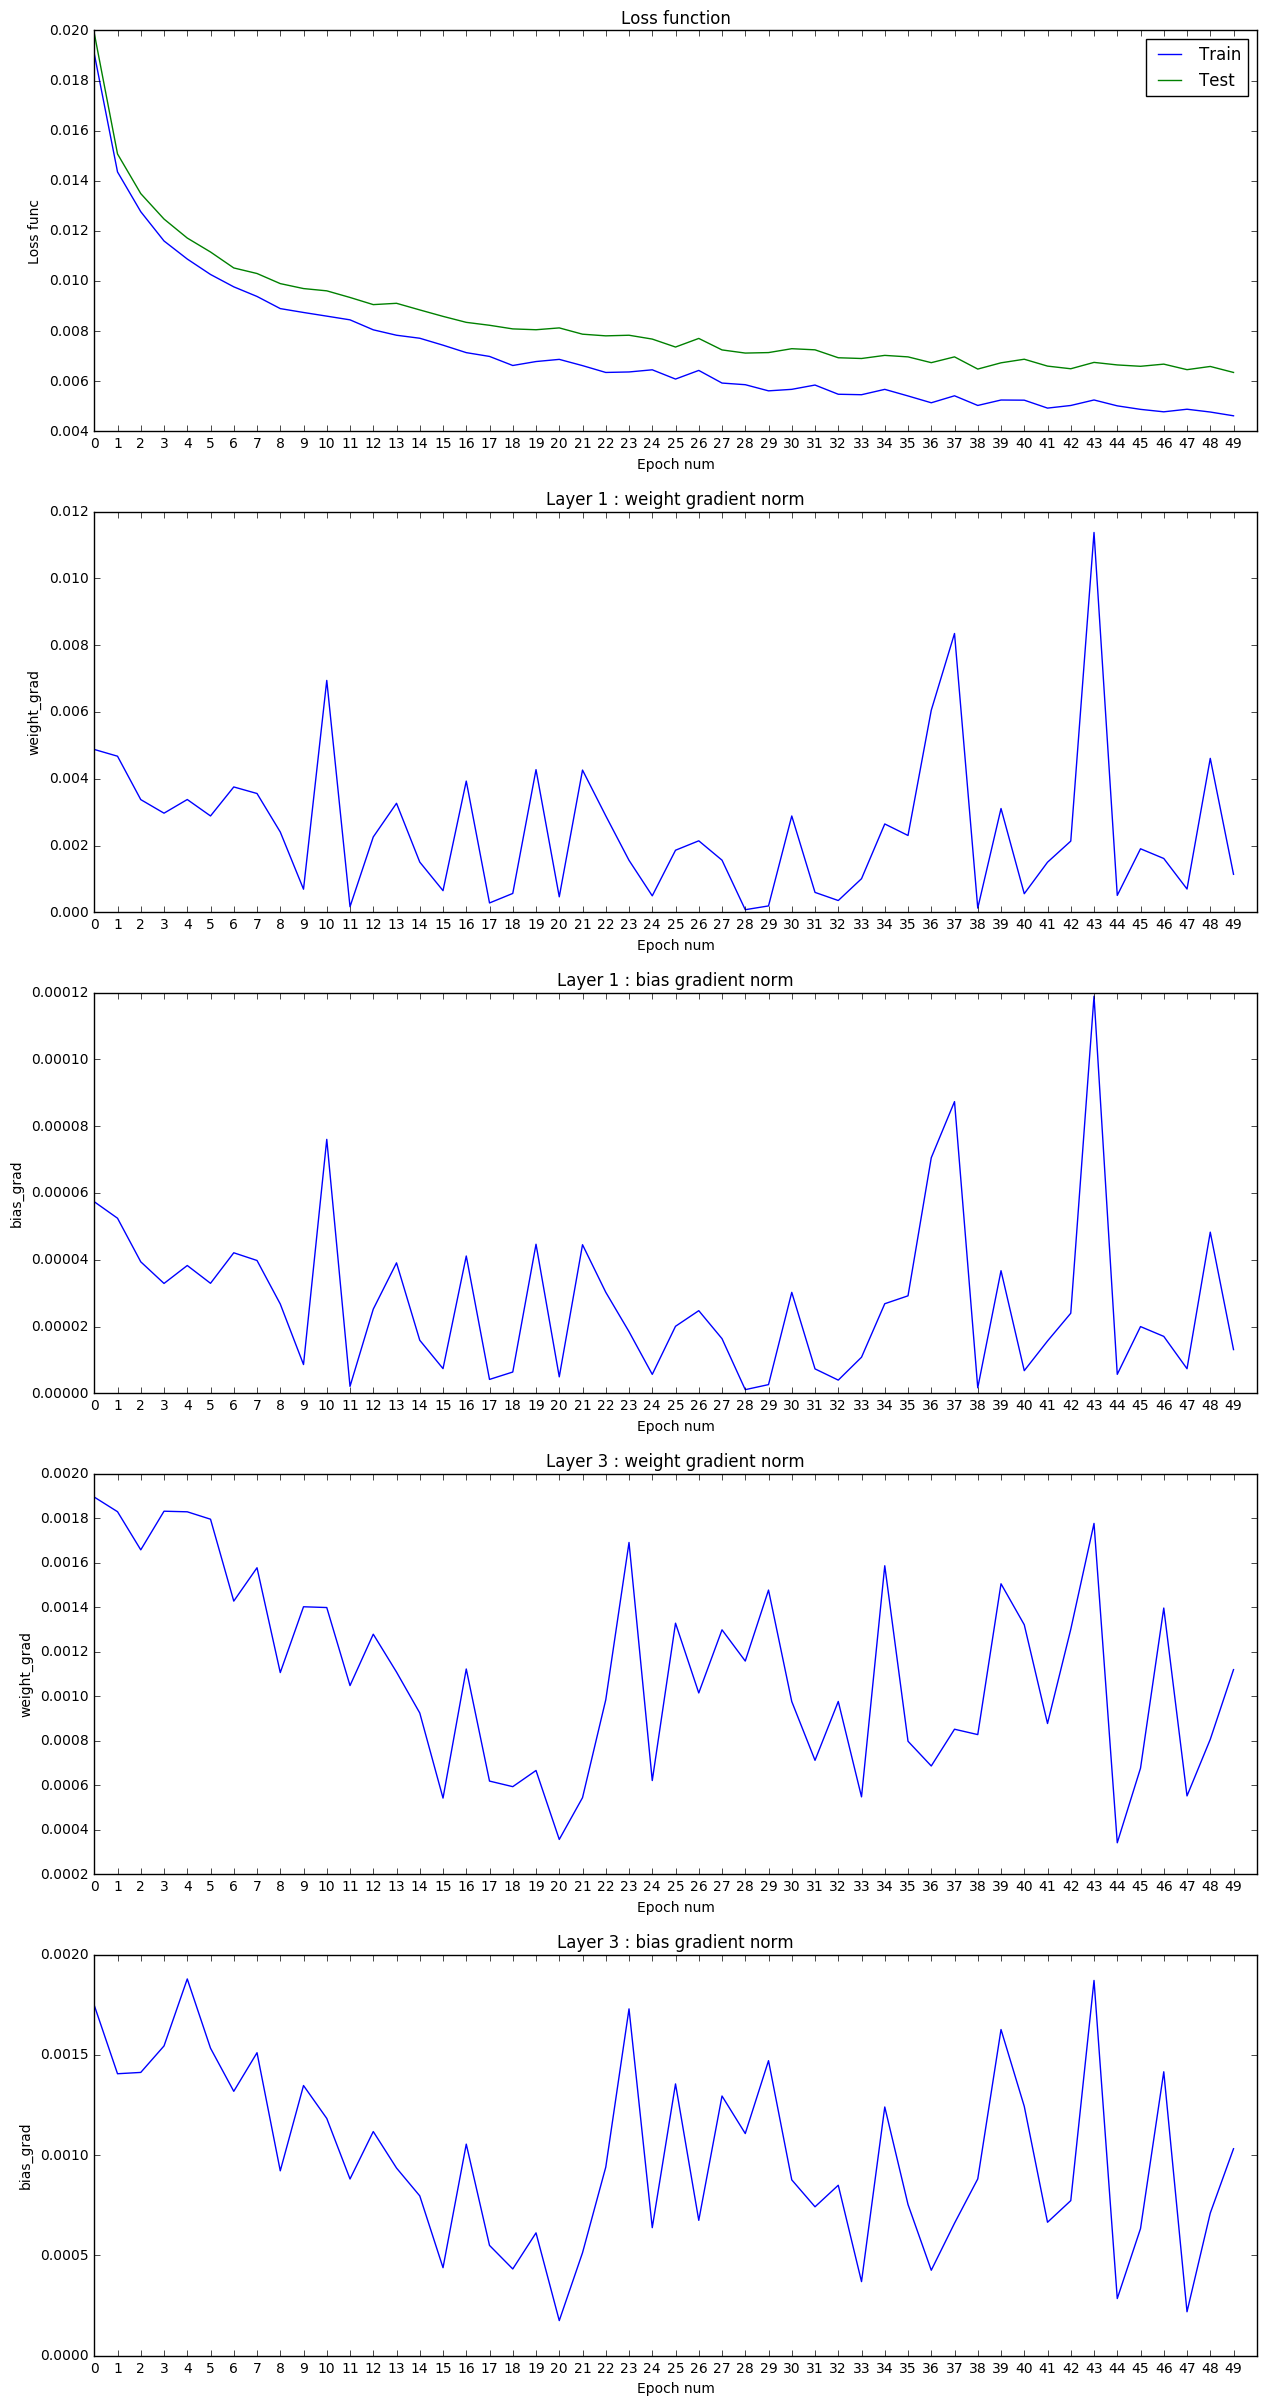

Train report
             precision    recall  f1-score   support

        0.0       0.98      0.98      0.98      4642
        1.0       0.99      0.98      0.99      5263
        2.0       0.97      0.97      0.97      4656
        3.0       0.97      0.96      0.96      4802
        4.0       0.97      0.98      0.97      4559
        5.0       0.97      0.96      0.97      4232
        6.0       0.97      0.99      0.98      4591
        7.0       0.97      0.97      0.97      4873
        8.0       0.96      0.97      0.96      4589
        9.0       0.96      0.96      0.96      4693

avg / total       0.97      0.97      0.97     46900

Test report
             precision    recall  f1-score   support

        0.0       0.97      0.98      0.98      2261
        1.0       0.98      0.98      0.98      2614
        2.0       0.96      0.95      0.95      2334
        3.0       0.96      0.95      0.95      2339
        4.0       0.95      0.96      0.96      2265
        5.0      

In [288]:
D_in = 784
D_out = 10
D_deep = 100 
model = torch.nn.Sequential(
          torch.nn.Linear(D_in, D_deep, bias = True),
          torch.nn.Tanh(),
          torch.nn.Linear(D_deep, D_out,  bias = True),
          torch.nn.Softmax()
)
loss_fn = torch.nn.MSELoss(size_average=True)


learning_rate = 1e-4

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


loss_arr, layer_arr, test_loss_arr = learn_on_model(X_TRAIN, Y_TRAIN_MOD, model, loss_fn, X_TEST,\
                                                    Y_TEST_MOD,\
                                                    learning_rate, epoch_temp = 1000, temp_change = 1,\
                                                    max_epoch_num=50, batch_size = 32)

draw_plots(model, loss_arr, layer_arr, test_loss_arr)
make_classification_report(model, X_TRAIN, Y_TRAIN, X_TEST, Y_TEST)

Попробуем MSE на нейросети с двумя скрытыми слоями. 

Execution take 861.24141717


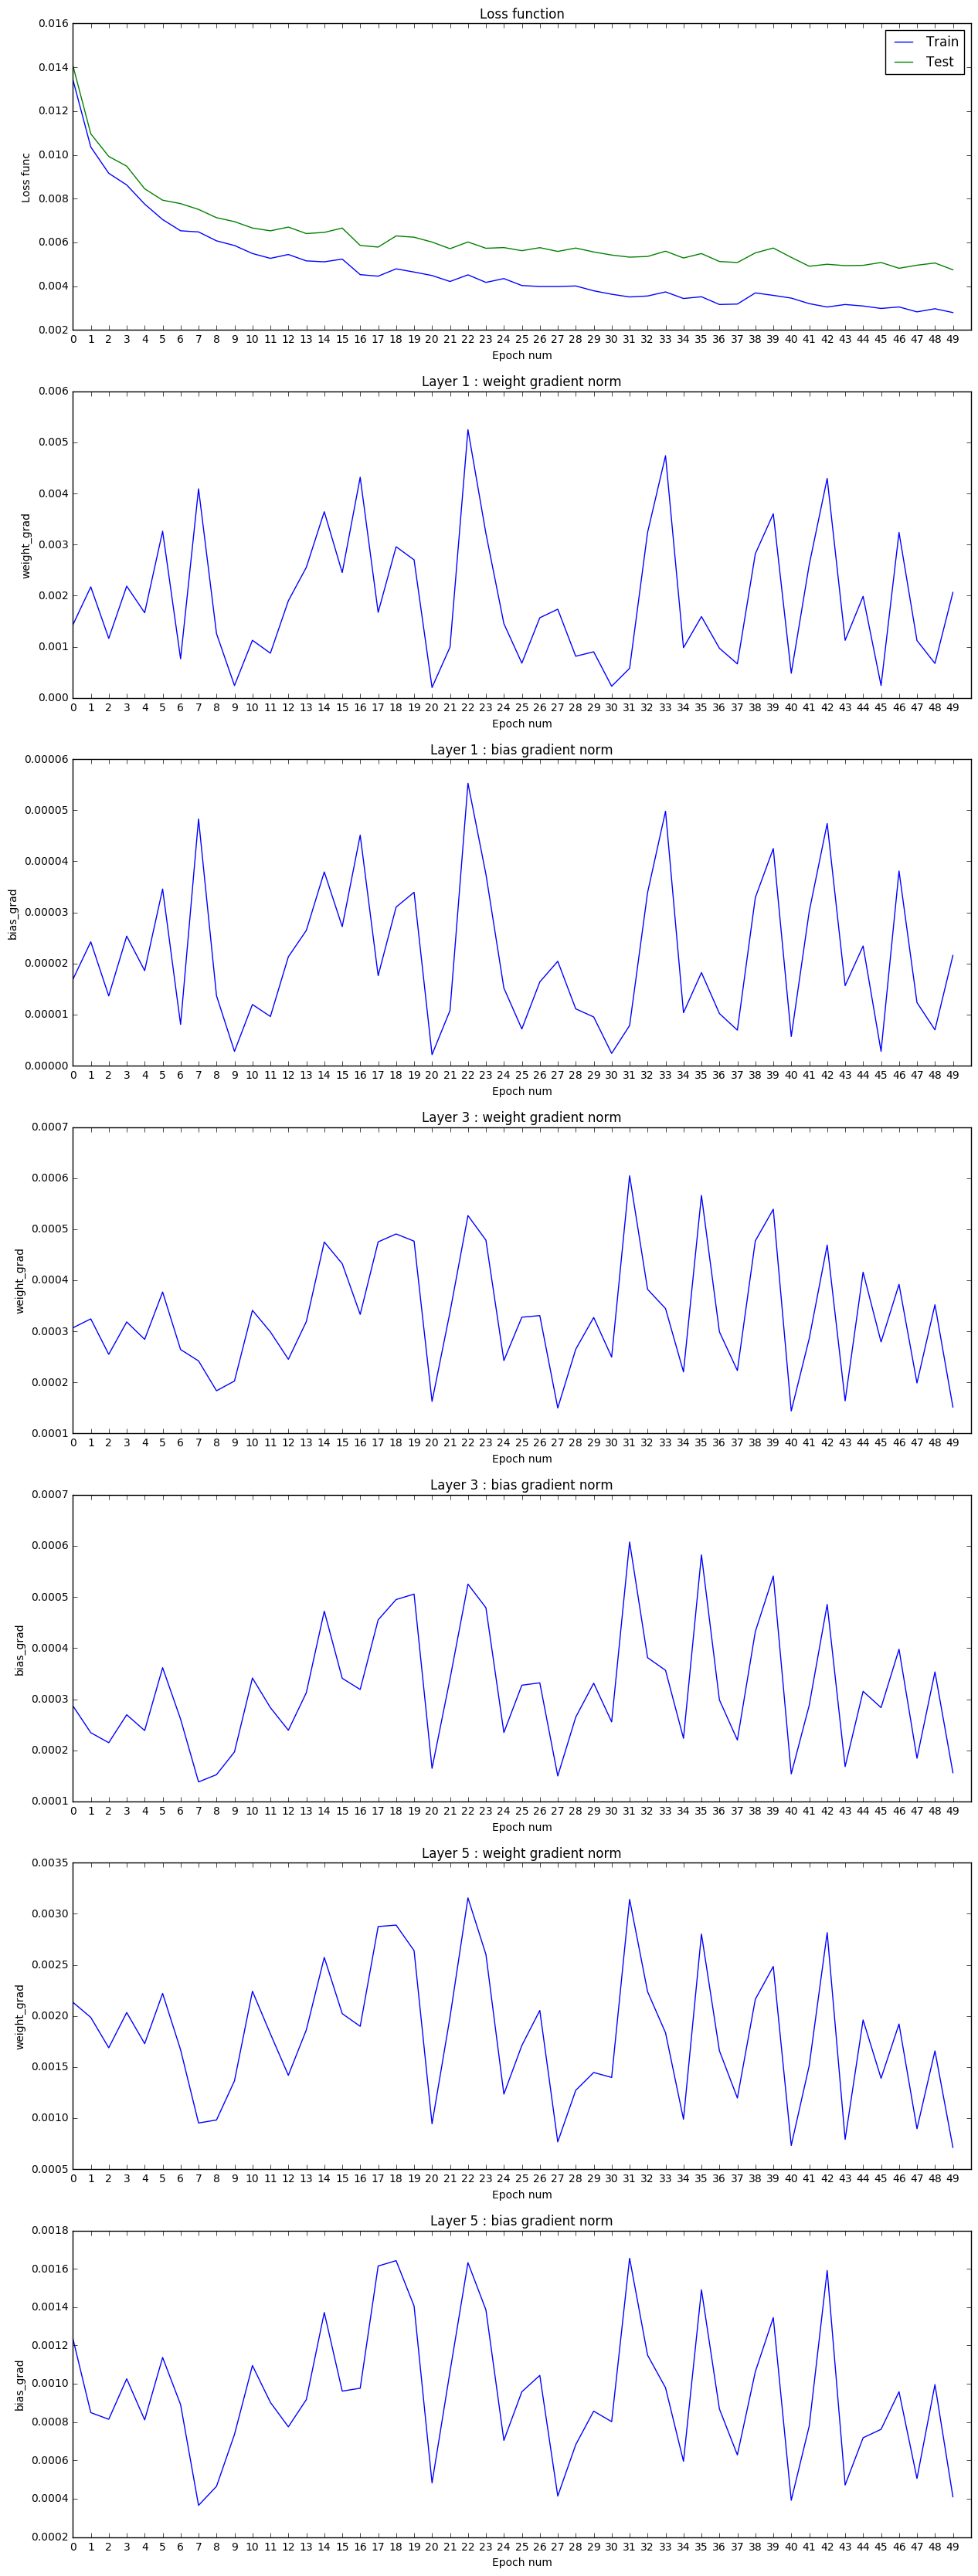

Train report
             precision    recall  f1-score   support

        0.0       0.99      0.98      0.99      4642
        1.0       0.99      0.99      0.99      5263
        2.0       0.98      0.98      0.98      4656
        3.0       0.98      0.97      0.98      4802
        4.0       0.99      0.98      0.98      4559
        5.0       0.98      0.98      0.98      4232
        6.0       0.98      0.99      0.99      4591
        7.0       0.99      0.99      0.99      4873
        8.0       0.96      0.98      0.97      4589
        9.0       0.98      0.97      0.98      4693

avg / total       0.98      0.98      0.98     46900

Test report
             precision    recall  f1-score   support

        0.0       0.99      0.98      0.98      2261
        1.0       0.98      0.98      0.98      2614
        2.0       0.97      0.97      0.97      2334
        3.0       0.97      0.96      0.96      2339
        4.0       0.98      0.95      0.97      2265
        5.0      

In [289]:
D_in = 784
D_out = 10
D_deep1 = 300 
D_deep2 = 100
model = torch.nn.Sequential(
          torch.nn.Linear(D_in, D_deep1, bias = True),
          torch.nn.Tanh(),
          torch.nn.Linear(D_deep1, D_deep2,  bias = True),
          torch.nn.LeakyReLU(),
          torch.nn.Linear(D_deep2, D_out,  bias = True),
          torch.nn.Softmax()
)
loss_fn = torch.nn.MSELoss(size_average=True)


learning_rate = 1e-4

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


loss_arr, layer_arr, test_loss_arr = learn_on_model(X_TRAIN, Y_TRAIN_MOD, model, loss_fn, X_TEST,\
                                                    Y_TEST_MOD,\
                                                    learning_rate, epoch_temp = 1000, temp_change = 1,\
                                                    max_epoch_num=50, batch_size = 32)

draw_plots(model, loss_arr, layer_arr, test_loss_arr)
make_classification_report(model, X_TRAIN, Y_TRAIN, X_TEST, Y_TEST)

Видим небольшее улучшение (как и в случае с NLL при добавлении второго скрытого слоя).
Под конец попробуем обучить модель меняя learning rate в ходе обучения от больших значений к маленьким. Будем использовать одну из первых хороших моделей

In [ ]:
D_in = 784
D_out = 10
D_deep = 100 
model = torch.nn.Sequential(
          torch.nn.Linear(D_in, D_deep),
          torch.nn.Sigmoid(),
          torch.nn.Linear(D_deep, D_out),
          torch.nn.LogSoftmax()
)
loss_fn = torch.nn.NLLLoss(size_average=True)

learning_rate = 1e-1

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


loss_arr, layer_arr, test_loss_arr = learn_on_model(X_TRAIN, Y_TRAIN.type(torch.LongTensor), model, loss_fn, X_TEST,\
                                                    Y_TEST.type(torch.LongTensor),\
                                                    learning_rate, epoch_temp = 10, temp_change = np.e,\
                                                    max_epoch_num=100, batch_size = 32)

draw_plots(model, loss_arr, layer_arr, test_loss_arr)
make_classification_report(model, X_TRAIN, Y_TRAIN, X_TEST, Y_TEST)

Качество существенно не улучшилось. Таким образом видим, что задача классификации изображений цифр из MNIST достаточно проста 
и очень многие архитектуры способны ее качественно решить. 
Я бы выбрал модель, использованную еще в самом начале, конкретно: